# TP N°2 — Minería de Datos (TUIA)
**Año:** 2025 • **Materia:** Data Mining • **Integrantes:** Fabrizio Tapia, Sebastian Palacio

**Datasets:**  
- 1000_Companies.csv (Predicción de ganancias empresariales)
- drugType.csv (Clasificación de tipo de droga farmacéutica)

**Objetivo:**  
Aplicar técnicas de aprendizaje supervisado (Árboles de Decisión, Naive Bayes y k-NN) para resolver problemas de regresión y clasificación multiclase.

---
# Parte 1: Predicción de Ganancias Empresariales (Regresión)

**Dataset:** 1000_Companies.csv  
**Objetivo:** Predecir el atributo `Profit` utilizando árboles de decisión para regresión

## 1.1 Importación de Librerías

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
from graphviz import Source

from feature_engine.outliers import Winsorizer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder
import warnings

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix




## 1.2 Carga y Exploración Inicial del Dataset

In [234]:
# Cargar dataset
datos_empresas = pd.read_csv('1000_Companies.csv')

# Información general
print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {datos_empresas.shape[0]} filas x {datos_empresas.shape[1]} columnas")
print(f"\nColumnas: {list(datos_empresas.columns)}")
print(f"\nTipos de datos:")
print(datos_empresas.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 1000 filas x 5 columnas

Columnas: ['RyD_Spend', 'Administration', 'MarketingSpend', 'State', 'Profit']

Tipos de datos:
RyD_Spend         float64
Administration    float64
MarketingSpend    float64
State              object
Profit            float64
dtype: object


In [235]:
diccionario_variables = {
    'RyD_Spend': 'Gasto en Investigación y Desarrollo (I+D)',
    'Administration': 'Gastos Administrativos',
    'MarketingSpend': 'Gasto en Marketing',
    'State': 'Estado donde opera la empresa (New York, California, Florida)',
    'Profit': 'Ganancia de la empresa (Variable Objetivo)'
}

print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_variables.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• RyD_Spend            → Gasto en Investigación y Desarrollo (I+D)
• Administration       → Gastos Administrativos
• MarketingSpend       → Gasto en Marketing
• State                → Estado donde opera la empresa (New York, California, Florida)
• Profit               → Ganancia de la empresa (Variable Objetivo)


In [236]:
# Estadísticas descriptivas
datos_empresas.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [237]:
# Verificar valores faltantes
print("VALORES FALTANTES:\n")

faltantes = datos_empresas.isnull().sum()

faltantes_pct = (faltantes / len(datos_empresas)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")

print(f"DUPLICADOS: {datos_empresas.duplicated().sum()}")
datos_empresas = datos_empresas.drop_duplicates()


VALORES FALTANTES:

          Columna  Valores Faltantes  Porcentaje
0       RyD_Spend                  0         0.0
1  Administration                  0         0.0
2  MarketingSpend                  0         0.0
3           State                  0         0.0
4          Profit                  0         0.0


DUPLICADOS: 1


## 1.3 Análisis Exploratorio de Datos (EDA)

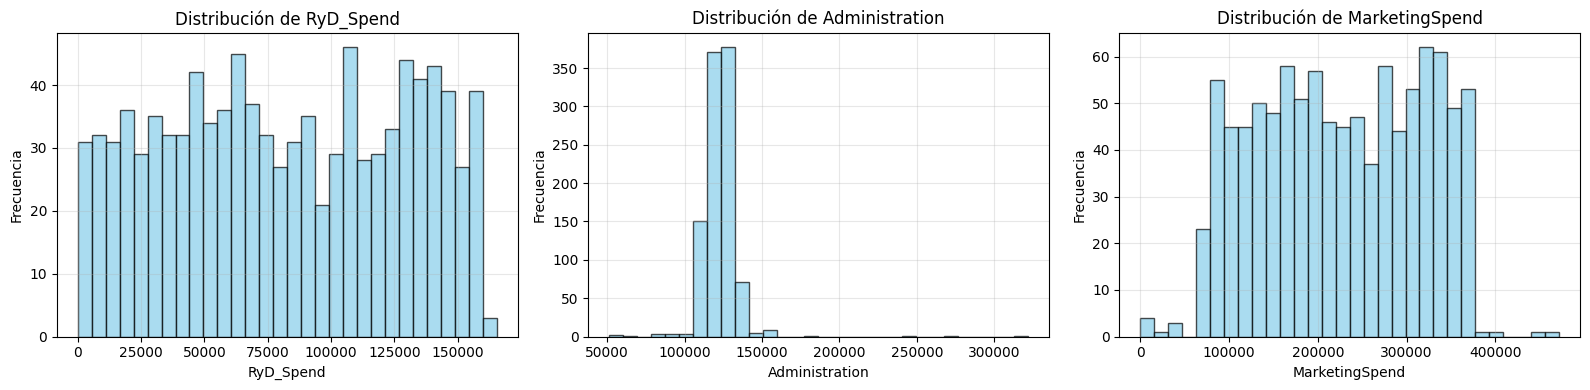

In [238]:
# Distribución de variables numéricas
columnas_numericas = ['RyD_Spend', 'Administration', 'MarketingSpend']

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].hist(datos_empresas[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

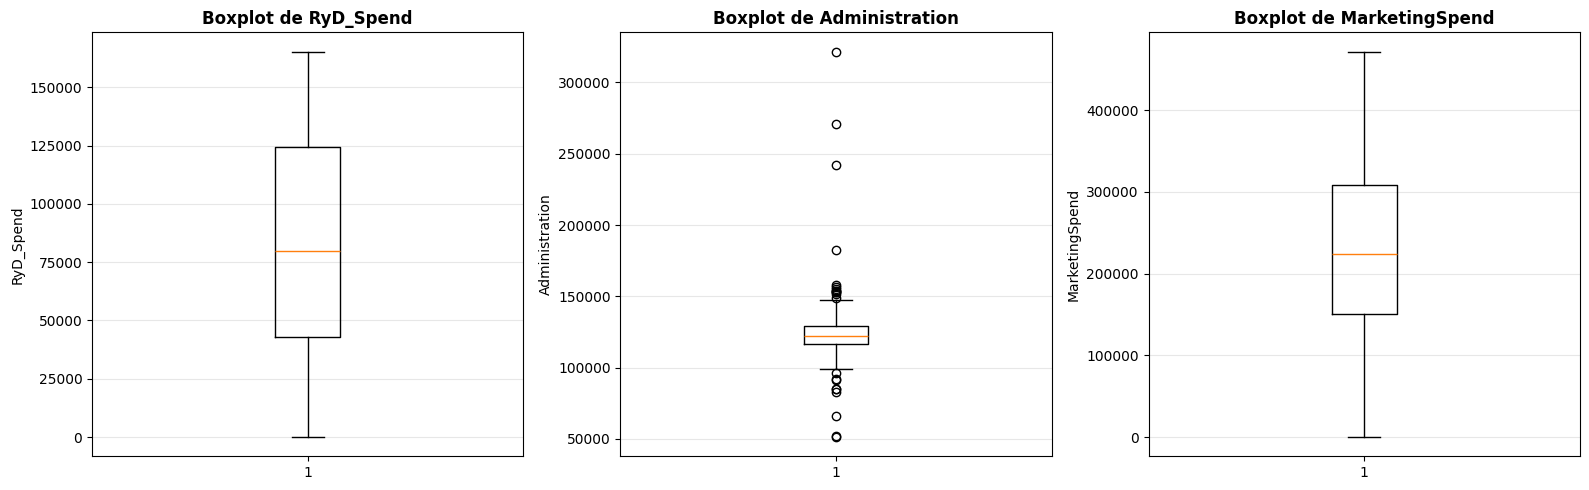

In [239]:
# Boxplots de las 3 variables predictoras numéricas
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(columnas_numericas):
    axes[i].boxplot(datos_empresas[col], vert=True)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

 ------------------------------ JUSTIFICAR NO ELIMINACION DE OUTLIERS

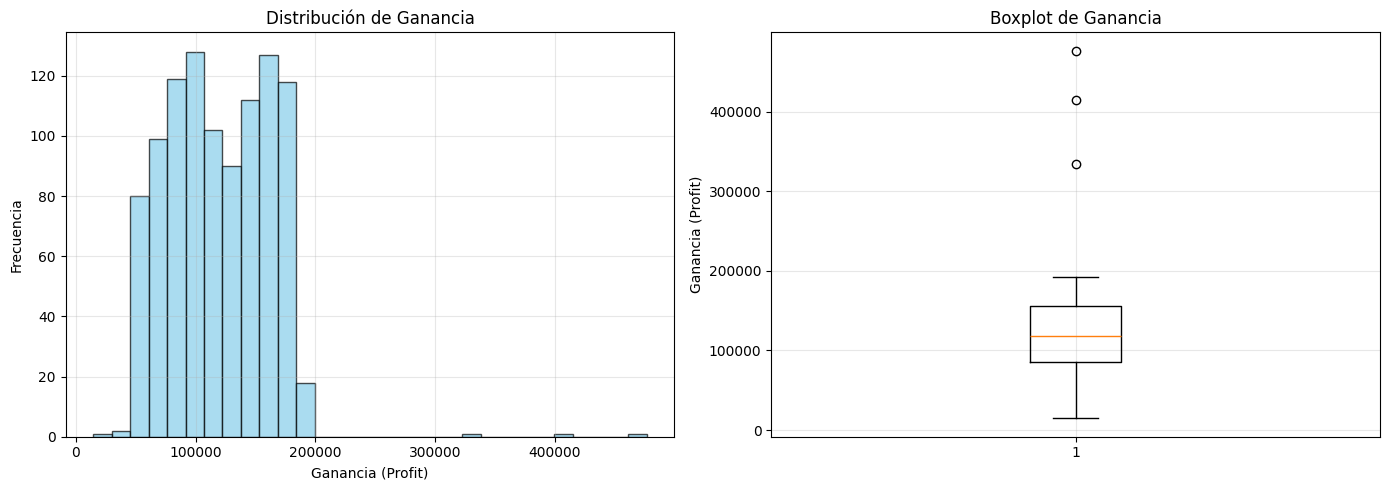

Media de Ganancia: $119,544.46
Mediana de Ganancia: $117,637.62
Desviación estándar: $42,910.08


In [240]:
# Distribución de la variable objetivo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(datos_empresas['Profit'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Ganancia (Profit)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Ganancia')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(datos_empresas['Profit'], vert=True)
axes[1].set_ylabel('Ganancia (Profit)')
axes[1].set_title('Boxplot de Ganancia')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Media de Ganancia: ${datos_empresas['Profit'].mean():,.2f}")
print(f"Mediana de Ganancia: ${datos_empresas['Profit'].median():,.2f}")
print(f"Desviación estándar: ${datos_empresas['Profit'].std():,.2f}")

 ------------------------------ JUSTIFICAR NO ELIMINACION DE OUTLIERS


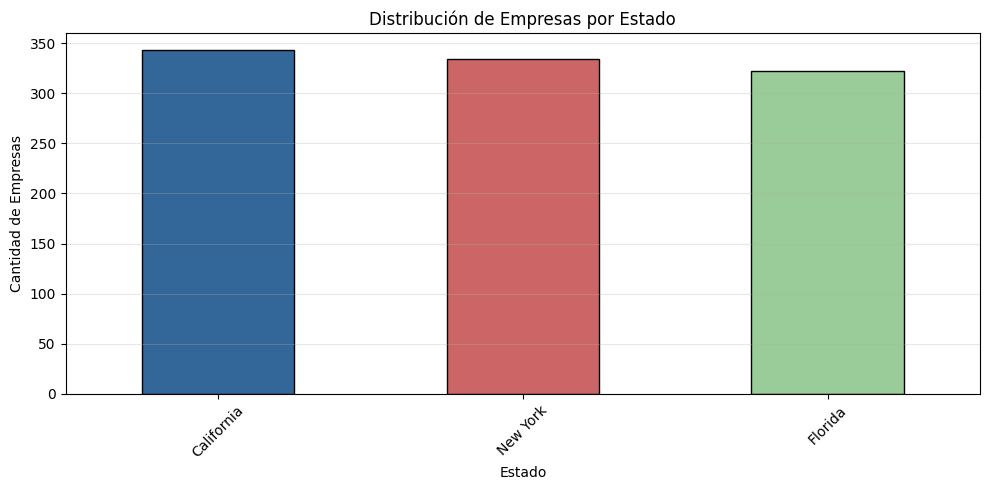


Distribución por Estado:
State
California    343
New York      334
Florida       322
Name: count, dtype: int64

Porcentaje por Estado:
State
California    34.33
New York      33.43
Florida       32.23
Name: count, dtype: float64


In [241]:
# Distribución de la variable categórica State
conteo_estados = datos_empresas['State'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99']

plt.figure(figsize=(10, 5))
conteo_estados.plot(kind='bar', color= paleta, edgecolor='black')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Empresas')
plt.title('Distribución de Empresas por Estado')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nDistribución por Estado:")
print(conteo_estados)
print(f"\nPorcentaje por Estado:")
print((conteo_estados / len(datos_empresas) * 100).round(2))

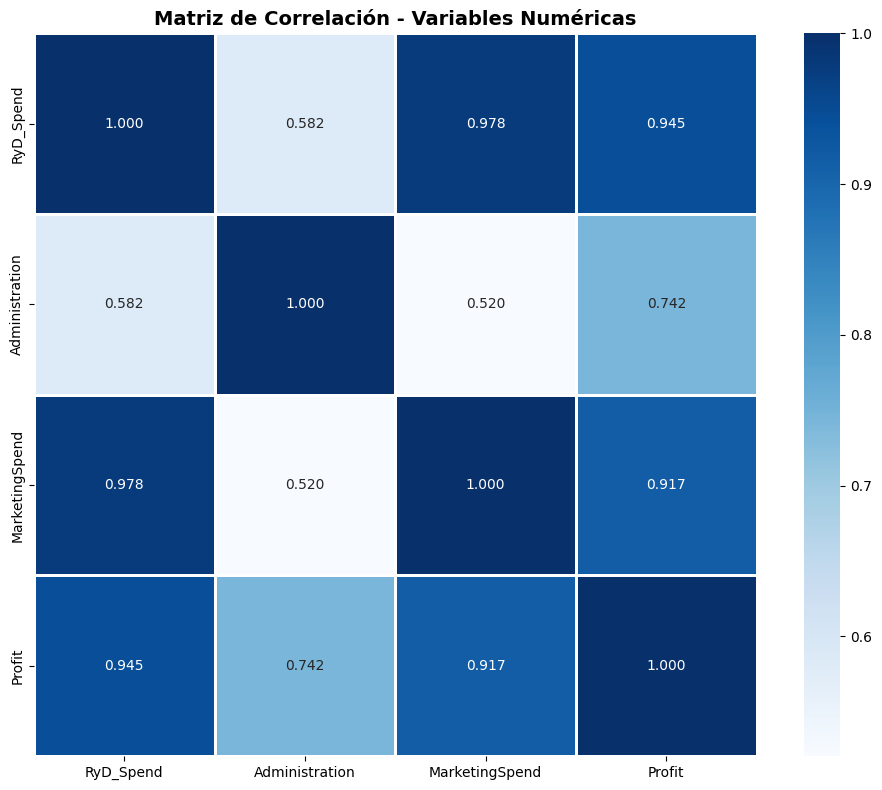


Correlación con Profit:
Profit            1.000000
RyD_Spend         0.945245
MarketingSpend    0.917270
Administration    0.741561
Name: Profit, dtype: float64


In [242]:
# Matriz de correlación
datos_numericos = datos_empresas.select_dtypes(include=[np.number])
matriz_correlacion = datos_numericos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, fmt='.3f', cmap='Blues', square=True, linewidths=1) # No usamos centrado para mejor visualización
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelación con Profit:")
print(matriz_correlacion['Profit'].sort_values(ascending=False))

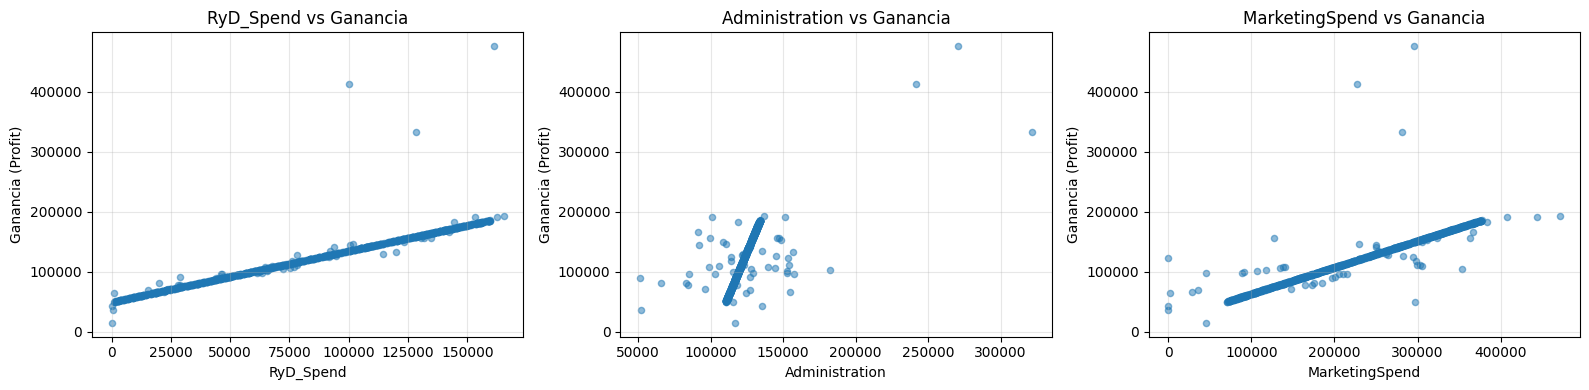

In [243]:
# Scatter plots: relación entre variables predictoras y Profit

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for i, col in enumerate(columnas_numericas):
    axes[i].scatter(datos_empresas[col], datos_empresas['Profit'], alpha=0.5, s=20)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Ganancia (Profit)')
    axes[i].set_title(f'{col} vs Ganancia')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Preprocesamiento

### Codificacion de variables categóricas 

In [244]:
# Codificación de variables categóricas
 
datos = pd.get_dummies(datos_empresas, columns=['State'], dtype=int)

datos.head()

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0,0,1
1,162597.70,151377.59,443898.53,191792.06,1,0,0
2,153441.51,101145.55,407934.54,191050.39,0,1,0
3,144372.41,118671.85,383199.62,182901.99,0,0,1
4,142107.34,91391.77,366168.42,166187.94,0,1,0


### Split 

In [245]:
# Separo variable target (Profit) de variables explicativas 

from re import X


X = datos.drop("Profit", axis=1)
y = datos["Profit"]

In [246]:
# Split train/test 80/20

from random import shuffle


primer_split = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

X_train_prim, X_test_prim, y_train_prim, y_test_prim = primer_split

print("X_train shape:", X_train_prim.shape)
print("X_test shape:", X_test_prim.shape)
print("y_train shape:", y_train_prim.shape)
print("y_test shape:", y_test_prim.shape)


X_train shape: (799, 6)
X_test shape: (200, 6)
y_train shape: (799,)
y_test shape: (200,)


In [247]:
# Split train/test 70/30

segundo_split = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_train_seg, X_test_seg, y_train_seg, y_test_seg = segundo_split

print("X_train shape:", X_train_seg.shape)
print("X_test shape:", X_test_seg.shape)
print("y_train shape:", y_train_seg.shape)
print("y_test shape:", y_test_seg.shape)

X_train shape: (699, 6)
X_test shape: (300, 6)
y_train shape: (699,)
y_test shape: (300,)


## Entrenamiento modelo arbol segun la practica, primer split


### esta implementacion de aca abajo serà mejor borrarla pq no se ve nada y quedamos con la siguiente que està un poco mejorada, tal vez implementar un grid search tambien,

In [248]:
# Selección del modelo: hiperparámetros
tree_reg = DecisionTreeRegressor(max_depth=5, criterion='squared_error',
                                 min_samples_leaf=1, min_samples_split=2,
                                 random_state=13)
# Entrenamiento
tree_reg.fit(X_train_prim, y_train_prim)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [249]:
# Lista de nombres de las variables
vars_names = list(X_train_prim.columns)
print(vars_names)

['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York']


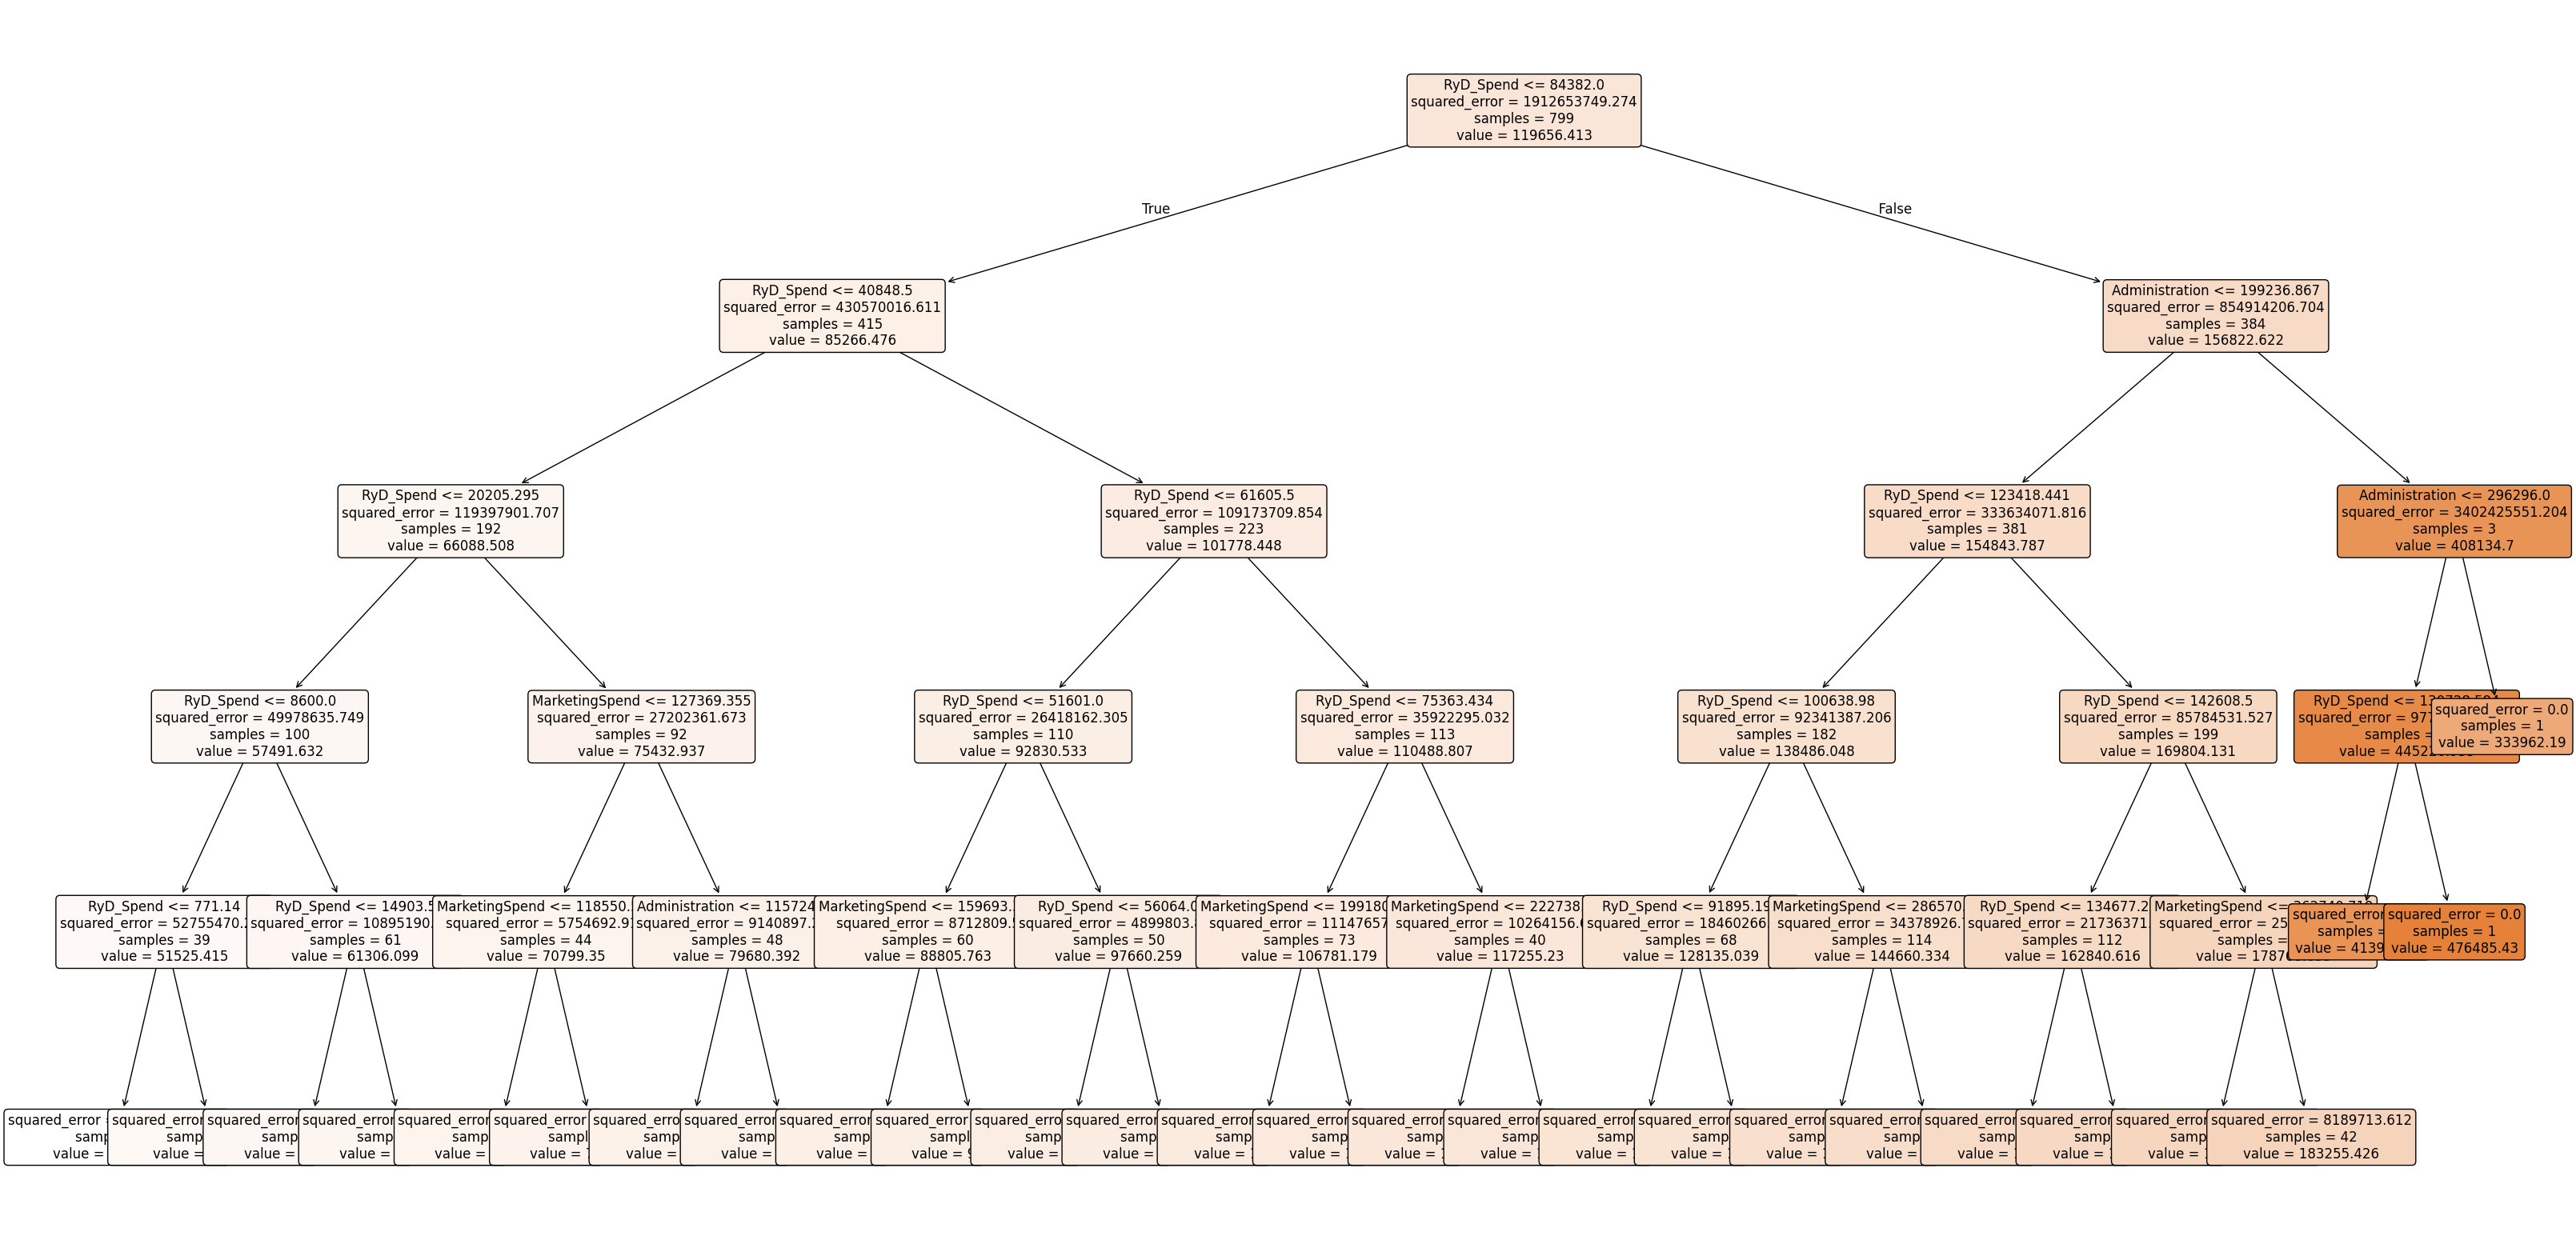

In [250]:
plt.figure(figsize=(40,20))
plot_tree(tree_reg, feature_names=vars_names, fontsize=12, filled=True,
               rounded=True)
plt.show()

In [251]:
# Predicción en el conjunto de entrenamiento
pred_trn = tree_reg.predict(X_train_prim)

# Predicción en el conjunto de validación
pred_val = tree_reg.predict(X_test_prim)

### implementacion un poco mejorada, para que se vea el arbol y con los parametros mejorados

In [252]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, r2_score
)
import numpy as np


tree_simple = DecisionTreeRegressor(
    max_depth=5,           
    min_samples_leaf=3,     
    random_state=13
)
tree_simple.fit(X_train_prim, y_train_prim)

# Predicciones
pred_train = tree_simple.predict(X_train_prim)
pred_test  = tree_simple.predict(X_test_prim)

# Métricas
def report(y_true, y_pred, title):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2   = r2_score(y_true, y_pred)
    print(f'\n=== {title} ===')
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('MAPE (%):', mape)
    print('R2:', r2)



# ============================================================
# PODRIAMOS SEPARAR EL CODIGO EN CELDAS PARA MAS LEGIBILIDAD
# ============================================================


report(y_train_prim, pred_train, 'TRAIN (árbol simple)')
report(y_test_prim,  pred_test,  'TEST  (árbol simple)')

importances = dict(zip(
    ['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York'],
    tree_simple.feature_importances_
))
print('\nImportancias de variables:', importances)


=== TRAIN (árbol simple) ===
MAE: 1943.9917466544775
RMSE: 4276.766733255721
MAPE (%): 1.7682214997888732
R2: 0.9904369864657293

=== TEST  (árbol simple) ===
MAE: 1689.7568976000207
RMSE: 2065.9964638287597
MAPE (%): 1.496392838619129
R2: 0.997240286495743

Importancias de variables: {'RyD_Spend': np.float64(0.8686027612804047), 'Administration': np.float64(0.12631795124911244), 'MarketingSpend': np.float64(0.005079287470482753), 'State_California': np.float64(0.0), 'State_Florida': np.float64(0.0), 'State_New York': np.float64(0.0)}


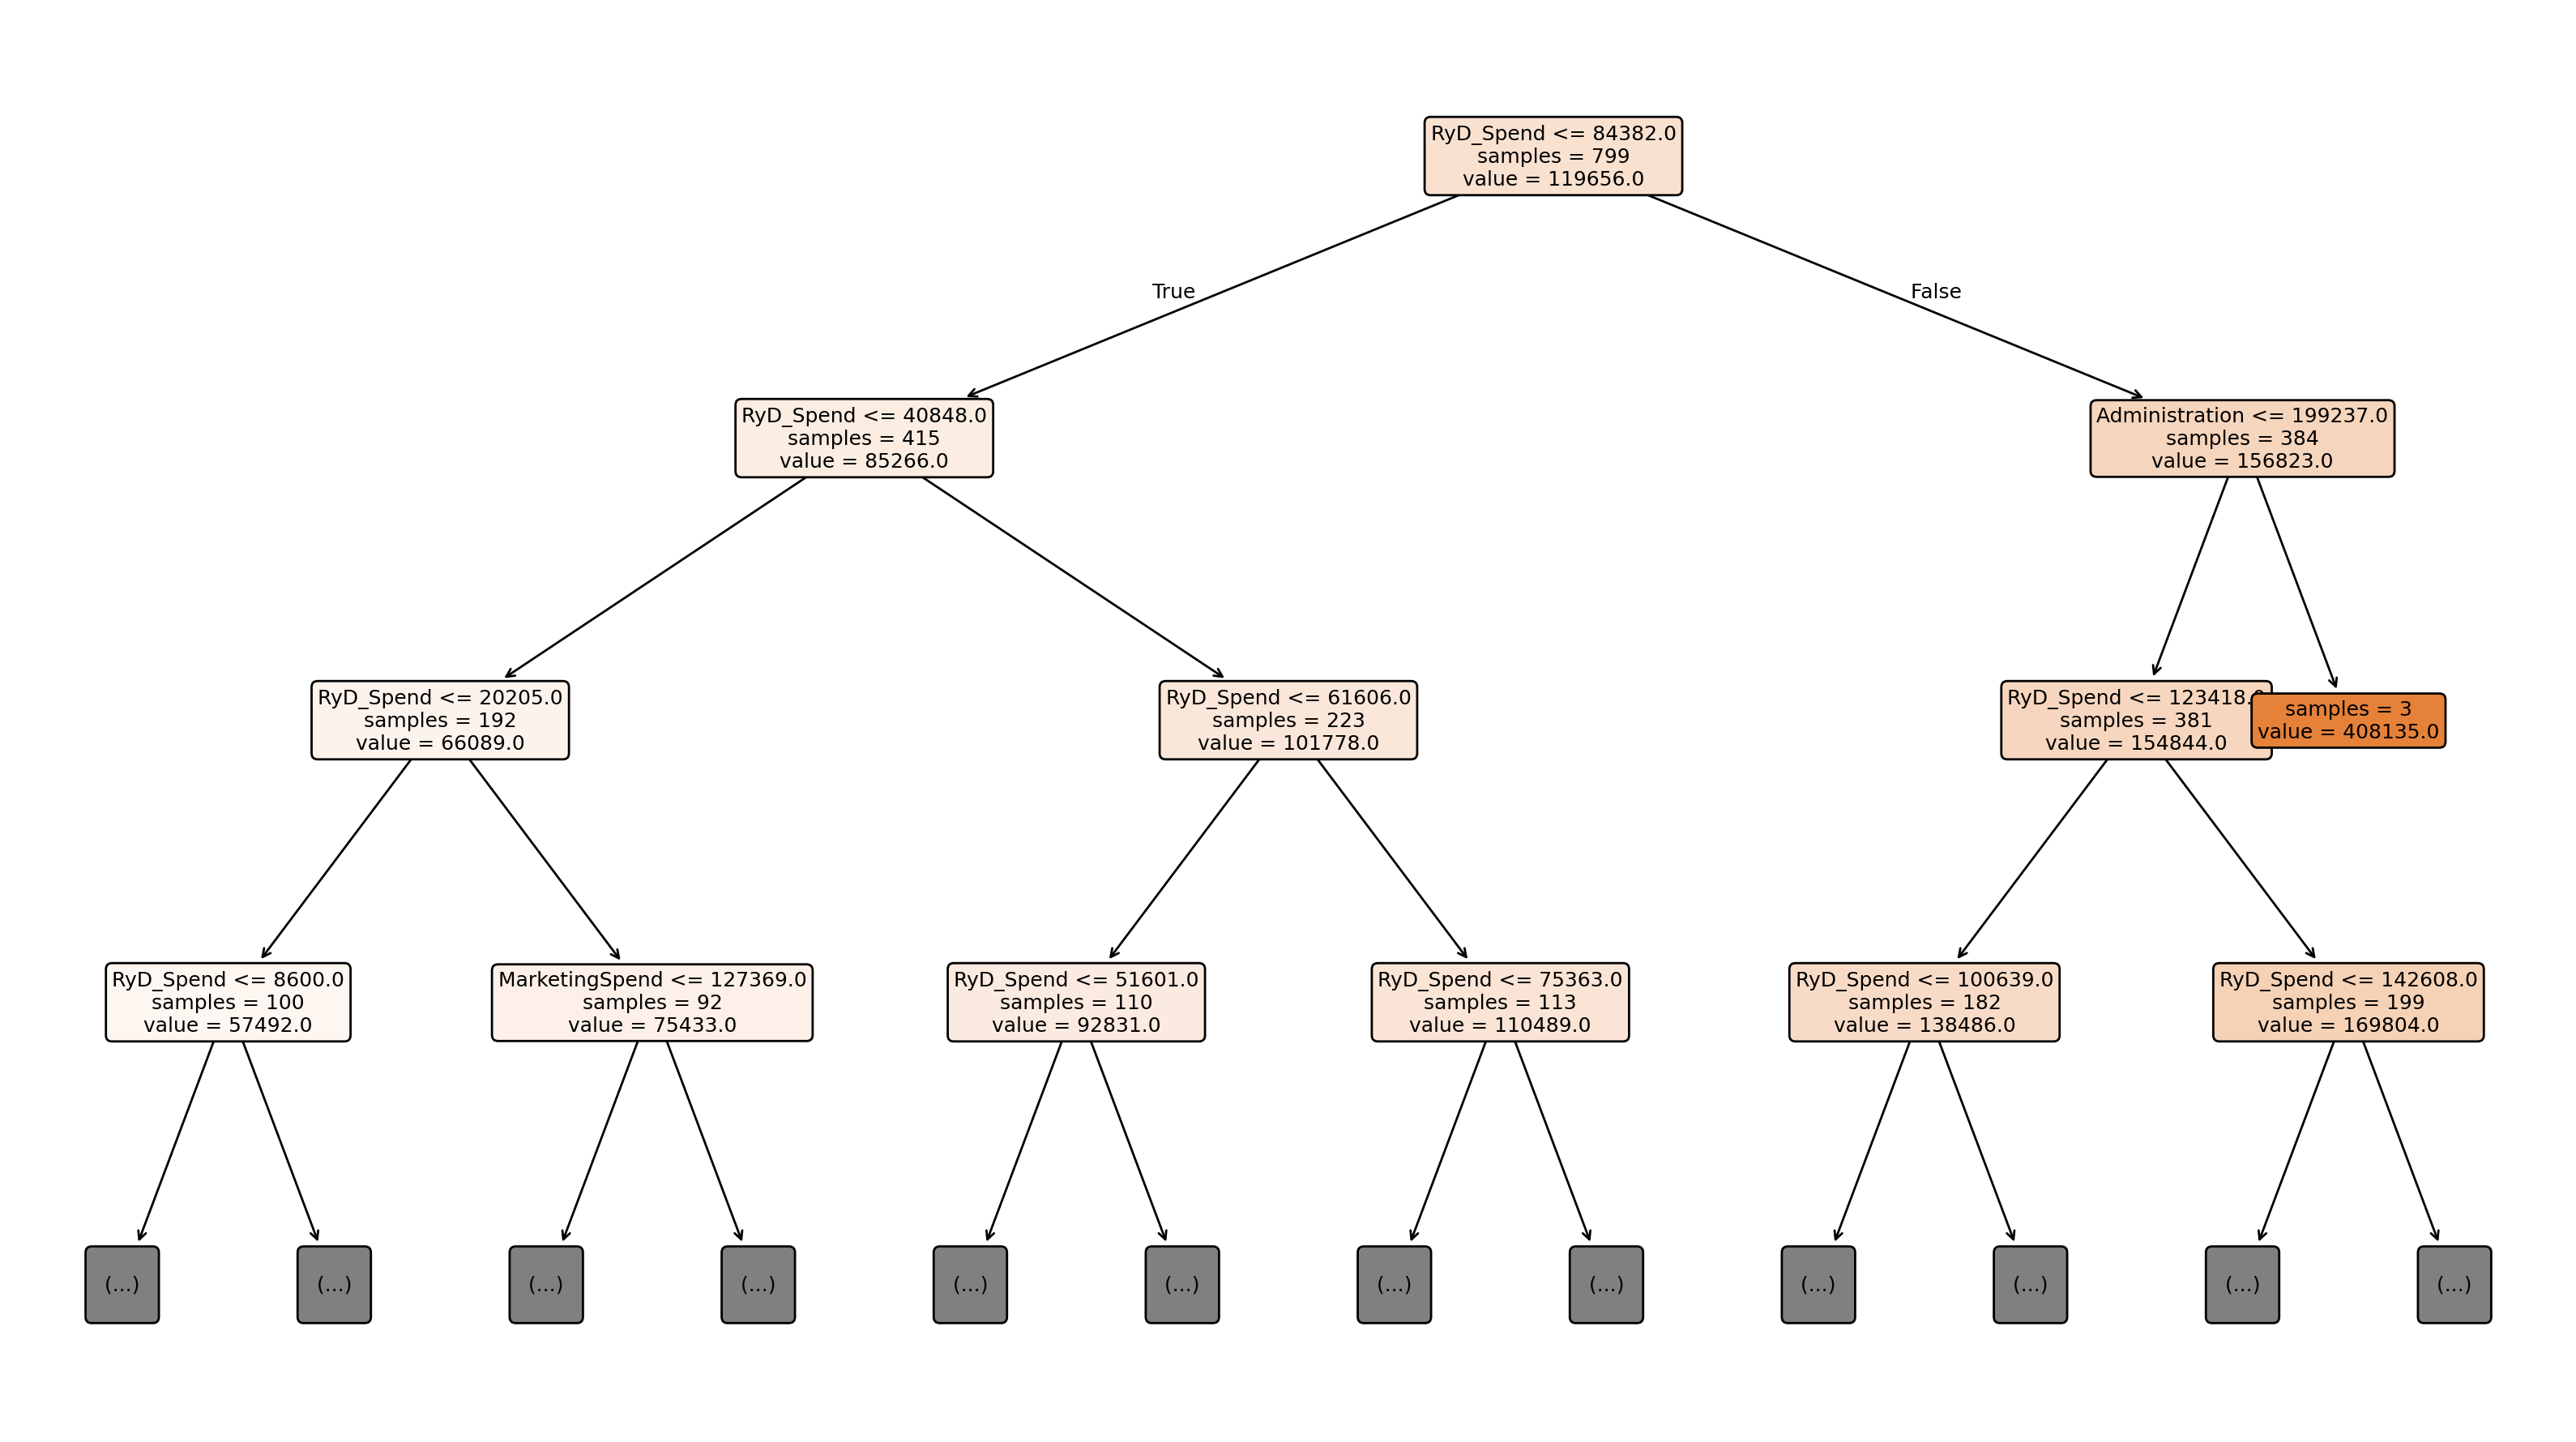

Profundidad total: 5
Cantidad de hojas: 25


In [253]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

feat_names = ['RyD_Spend','Administration','MarketingSpend',
              'State_California','State_Florida','State_New York']

plt.figure(figsize=(16, 9), dpi=200)
plot_tree(
    tree_simple,
    feature_names=feat_names,
    filled=True,
    rounded=True,
    max_depth=3,          # solo los 3 primeros niveles para claridad
    impurity=False,       # oculta MSE en nodos
    fontsize=9,
    precision=0           # sin decimales en valores
)
plt.tight_layout()
plt.savefig('arbol_regresion.png', dpi=300, bbox_inches='tight')
plt.show()
print('Profundidad total:', tree_simple.get_depth())
print('Cantidad de hojas:', tree_simple.get_n_leaves())

In [254]:
tableResult = pd.DataFrame({'Actual':y_test_prim, 'Predicted':pred_test})
tableResult.head()

,Actual,Predicted
453,85529.93509,86644.031543
794,59766.21593,58753.441302
209,61393.64099,58753.441302
309,100693.60690,98996.296807
740,91370.72519,91632.641558


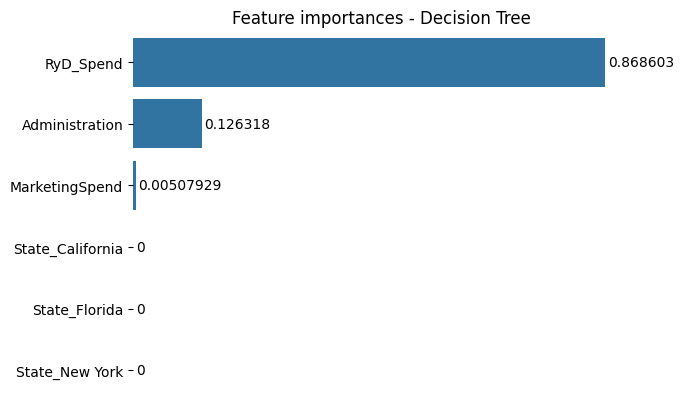

In [255]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': feat_names,
                            'importances': tree_simple.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

### Metricas

## Entrenamiento modelo arbol segun la practica, segundo split



### aca abajo es lo mismo que la primer implementacion de arriba, la deje para que quede como historial para que lo veas

In [256]:
# Selección del modelo: hiperparámetros
tree_reg_2 = DecisionTreeRegressor(max_depth=5, criterion='squared_error',
                                 min_samples_leaf=1, min_samples_split=2,
                                 random_state=13)
# Entrenamiento
tree_reg_2.fit(X_test_seg, y_test_seg)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


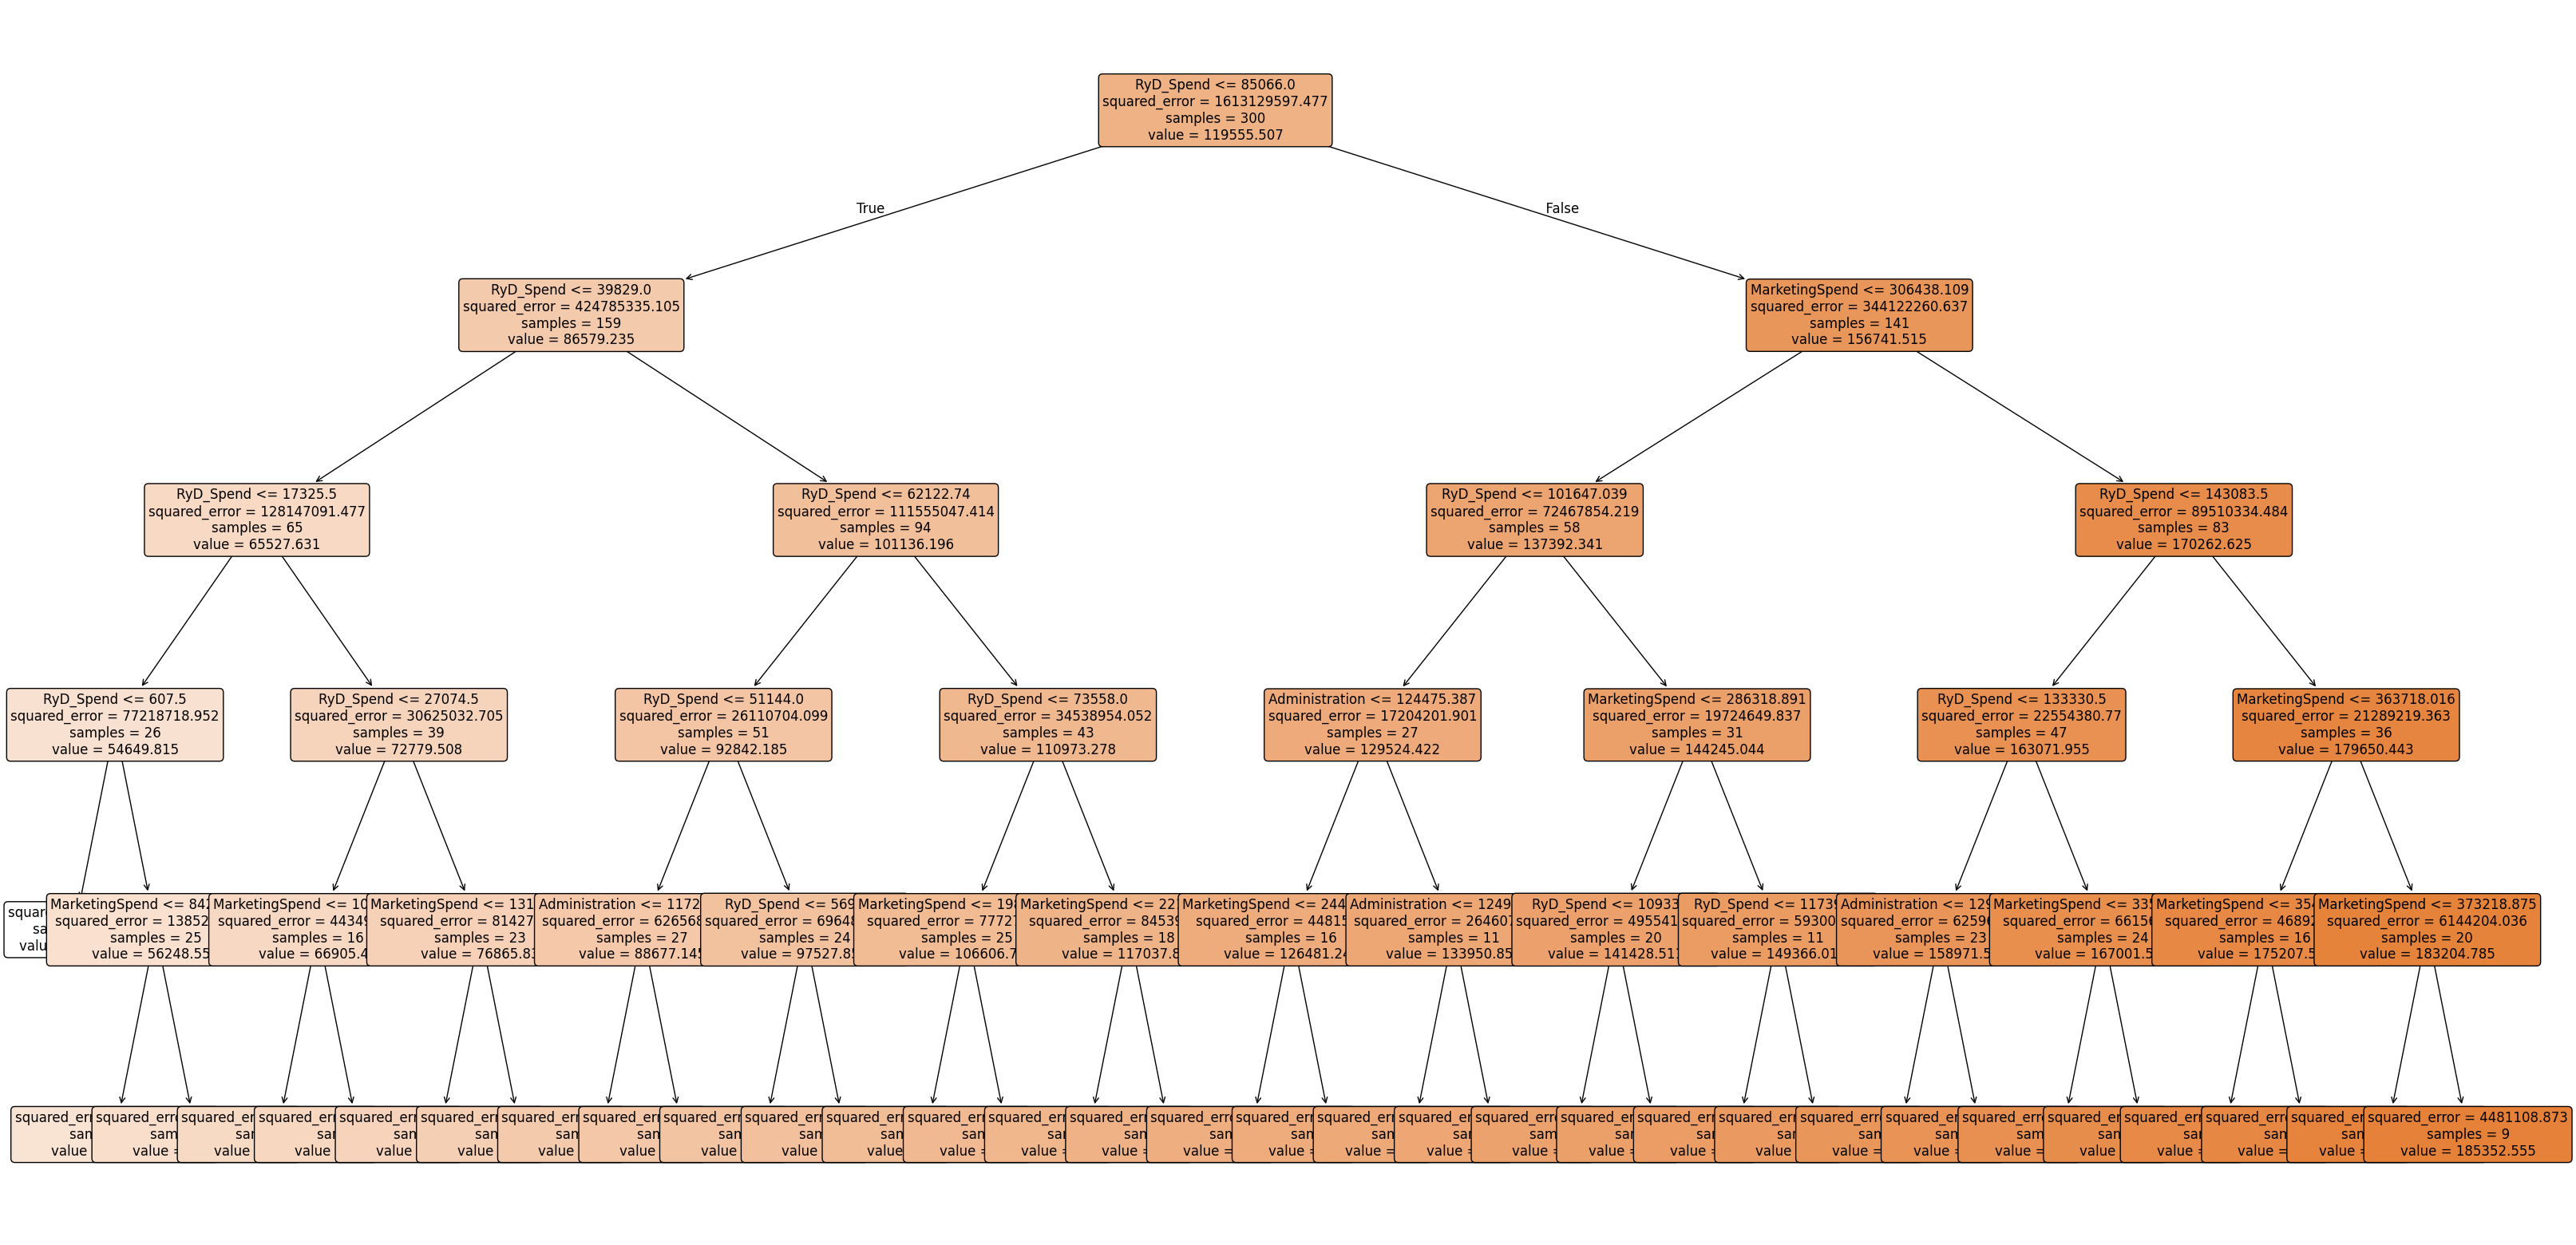

In [257]:
plt.figure(figsize=(40,20))
plot_tree(tree_reg_2, feature_names=vars_names, fontsize=12, filled=True,
               rounded=True)
plt.show()

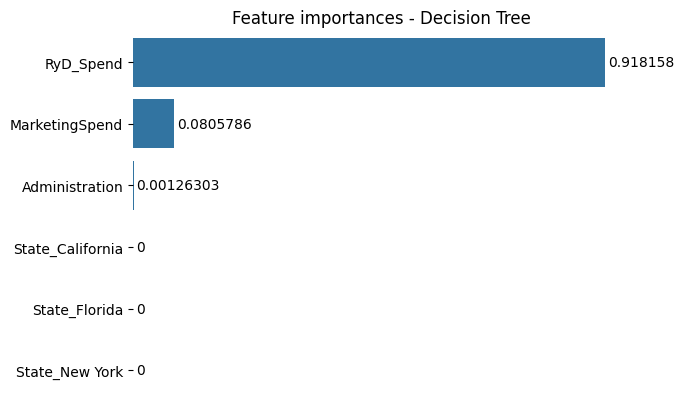

In [258]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': vars_names,
                            'importances': tree_reg_2.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

### implementacion mejorada split 2


In [259]:
tree_simple_2  = DecisionTreeRegressor(
    max_depth=5,           
    min_samples_leaf=3,     
    random_state=13
)
tree_simple_2.fit(X_train_seg, y_train_seg)

# Predicciones
pred_train_2 = tree_simple_2.predict(X_train_seg)
pred_test_2  = tree_simple_2.predict(X_test_seg)

# Métricas
def report(y_true, y_pred, title):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2   = r2_score(y_true, y_pred)
    print(f'\n=== {title} ===')
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('MAPE (%):', mape)
    print('R2:', r2)



# ============================================================
# PODRIAMOS SEPARAR EL CODIGO EN CELDAS PARA MAS LEGIBILIDAD
# ============================================================


report(y_train_seg, pred_train_2, 'TRAIN (árbol simple)')
report(y_test_seg,  pred_test_2,  'TEST  (árbol simple)')

importances = dict(zip(
    ['RyD_Spend', 'Administration', 'MarketingSpend', 'State_California', 'State_Florida', 'State_New York'],
    tree_simple_2.feature_importances_
))
print('\nImportancias de variables:', importances)


=== TRAIN (árbol simple) ===
MAE: 1902.0653352202462
RMSE: 4459.800065710172
MAPE (%): 1.5945018519046152
R2: 0.9897292916327254

=== TEST  (árbol simple) ===
MAE: 1968.3569026200084
RMSE: 3276.6472783668596
MAPE (%): 2.390650677449059
R2: 0.993344355342794

Importancias de variables: {'RyD_Spend': np.float64(0.8493932800779932), 'Administration': np.float64(0.1455094637025193), 'MarketingSpend': np.float64(0.005097256219487445), 'State_California': np.float64(0.0), 'State_Florida': np.float64(0.0), 'State_New York': np.float64(0.0)}


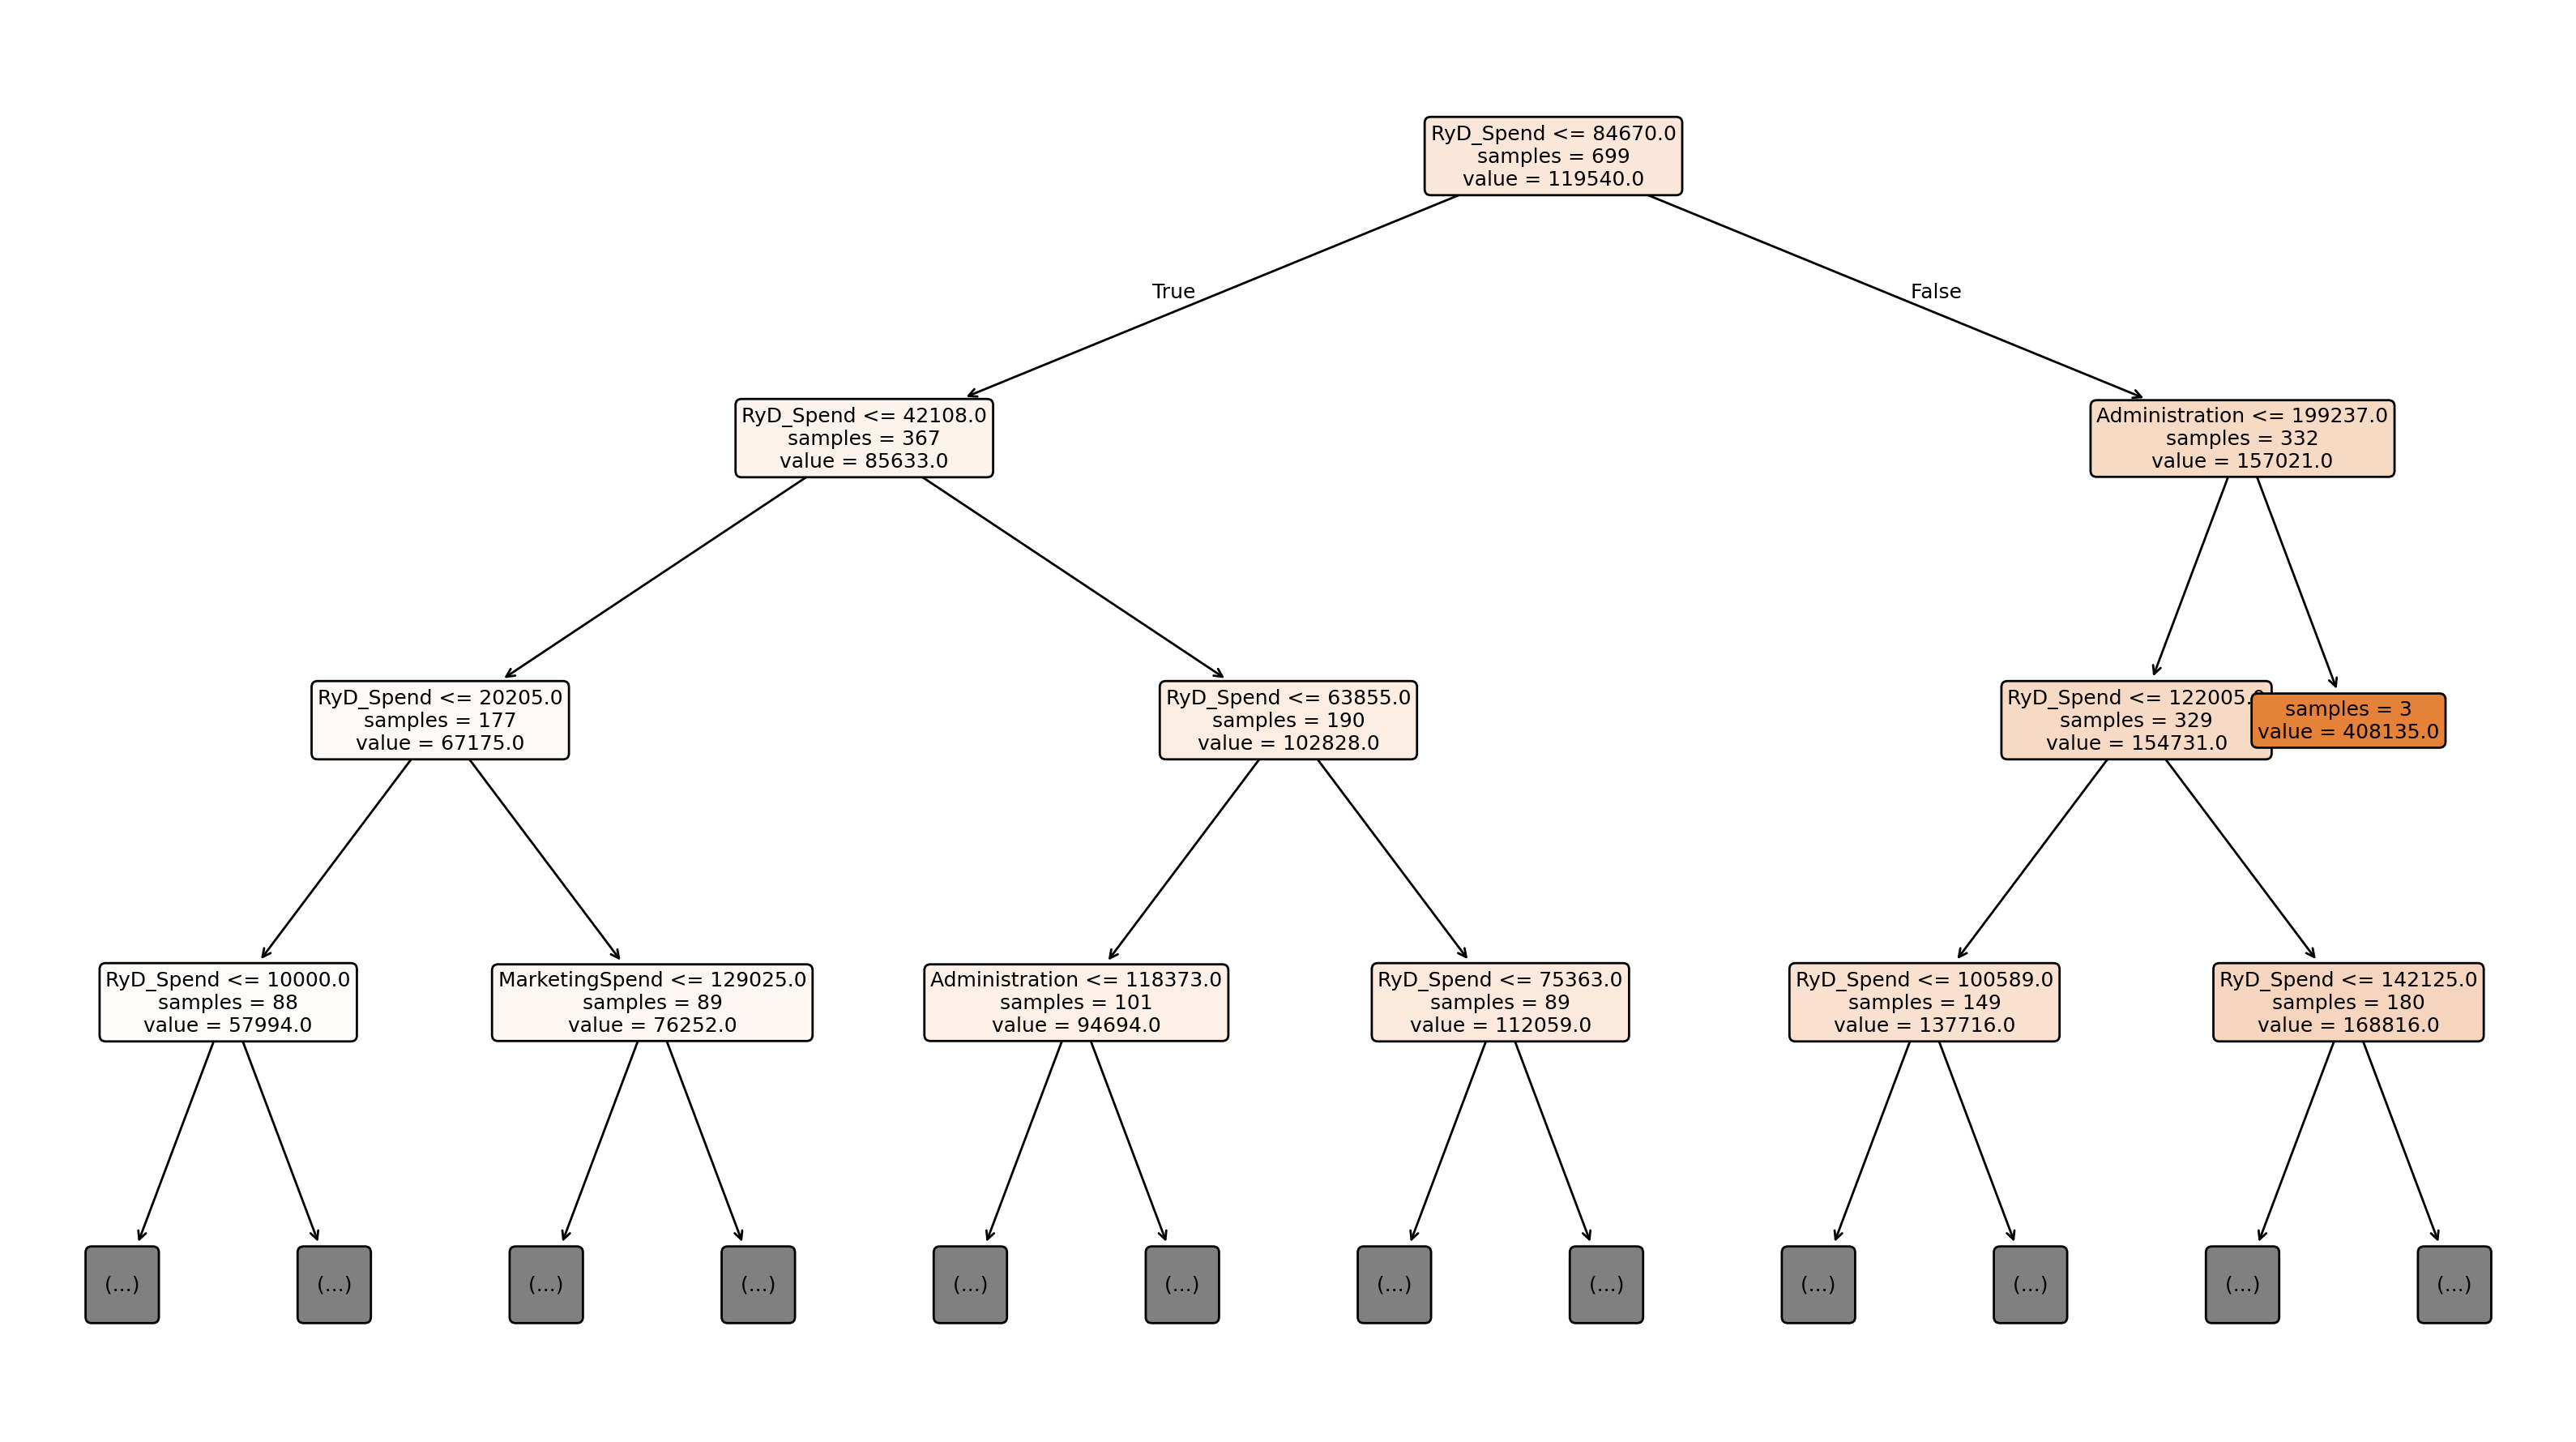

Profundidad total: 5
Cantidad de hojas: 25


In [260]:
feat_names = ['RyD_Spend','Administration','MarketingSpend',
              'State_California','State_Florida','State_New York']

plt.figure(figsize=(16, 9), dpi=200)
plot_tree(
    tree_simple_2,
    feature_names=feat_names,
    filled=True,
    rounded=True,
    max_depth=3,          # solo los 3 primeros niveles para claridad
    impurity=False,       # oculta MSE en nodos
    fontsize=9,
    precision=0           # sin decimales en valores
)
plt.tight_layout()
plt.savefig('arbol_regresion_split2.png', dpi=300, bbox_inches='tight')
plt.show()
print('Profundidad total:', tree_simple_2.get_depth())
print('Cantidad de hojas:', tree_simple_2.get_n_leaves())

In [261]:
tableResult = pd.DataFrame({'Actual':y_test_seg, 'Predicted':pred_test_2})
tableResult.head()

,Actual,Predicted
453,85529.93509,87525.461162
794,59766.21593,59526.197193
209,61393.64099,59526.197193
309,100693.60690,101842.971317
740,91370.72519,92461.965942


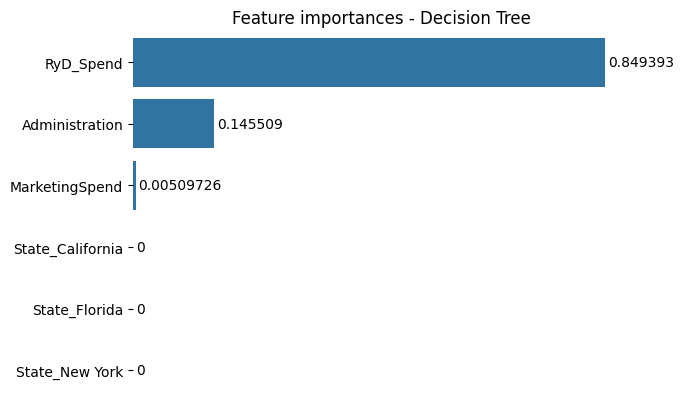

In [262]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': feat_names,
                            'importances': tree_simple_2.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Feature importances - Decision Tree')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

---
# Parte 2:

**Dataset:** drugType.csv  
**Objetivo:** Predecir la variable objetivo "Droga" 

## 1.1 Carga y Exploración Inicial del Dataset

In [263]:
# Cargar dataset
datos_drogas = pd.read_csv('drugType.csv')

# Información general
print("INFORMACIÓN GENERAL DEL DATASET \n")
print(f"Dimensiones: {datos_drogas.shape[0]} filas x {datos_drogas.shape[1]} columnas")
print(f"\nColumnas: {list(datos_drogas.columns)}")
print(f"\nTipos de datos:")
print(datos_drogas.dtypes)

INFORMACIÓN GENERAL DEL DATASET 

Dimensiones: 200 filas x 6 columnas

Columnas: ['Edad', 'Sexo', 'BP', 'Colesterol', 'Na_a_K', 'Droga']

Tipos de datos:
Edad            int64
Sexo           object
BP             object
Colesterol     object
Na_a_K        float64
Droga          object
dtype: object


In [264]:
diccionario_var_drogas = {
    "Edad": "Edad en años",
    "Sexo": "Sexo Masculino/Femenino",
    "BP": "Presion arterial Bajo/Normal/Alto",
    "Colesterol": "Colesterol Alto/Normal",
    "Na_a_K": "Ratio de Na a K (Variable continua)",
    "Droga": "Tipo de droga A/B/C/D/E"
}


print("DICCIONARIO DE VARIABLES \n")

for variable, descripcion in diccionario_var_drogas.items():
    print(f"• {variable:20s} → {descripcion}")

DICCIONARIO DE VARIABLES 

• Edad                 → Edad en años
• Sexo                 → Sexo Masculino/Femenino
• BP                   → Presion arterial Bajo/Normal/Alto
• Colesterol           → Colesterol Alto/Normal
• Na_a_K               → Ratio de Na a K (Variable continua)
• Droga                → Tipo de droga A/B/C/D/E


In [265]:
datos_drogas.describe()

,Edad,Na_a_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [266]:
# Verificar valores faltantes
print("VALORES FALTANTES:\n")

faltantes = datos_drogas.isnull().sum()

faltantes_pct = (faltantes / len(datos_drogas)) * 100

df_faltantes = pd.DataFrame({
    'Columna': faltantes.index,
    'Valores Faltantes': faltantes.values,
    'Porcentaje': faltantes_pct.values
})

print(df_faltantes)
print("\n")

# Duplicados
print(f"DUPLICADOS: {datos_drogas.duplicated().sum()}")
datos_drogas.drop_duplicates()
datos_drogas.shape


VALORES FALTANTES:

      Columna  Valores Faltantes  Porcentaje
0        Edad                  0         0.0
1        Sexo                  0         0.0
2          BP                  0         0.0
3  Colesterol                  0         0.0
4      Na_a_K                  0         0.0
5       Droga                  0         0.0


DUPLICADOS: 0


(200, 6)

Este conjunto no presenta valores faltantes ni duplicados. 

## 1.2 Análisis Exploratorio de Datos (EDA)

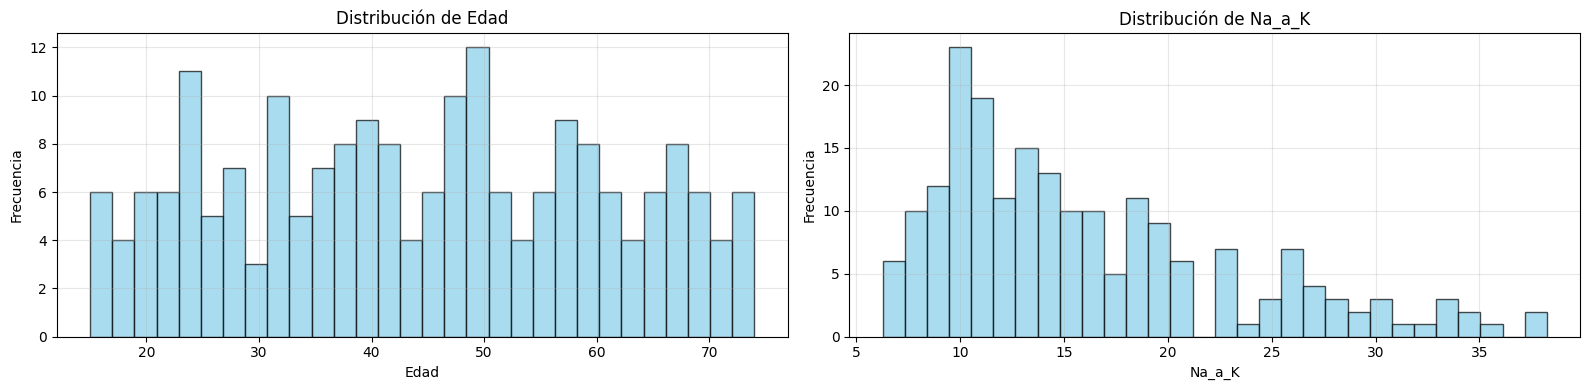

In [267]:
# Distribución de variables numéricas
numericas_drogas = ['Edad', 'Na_a_K']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

for i, col in enumerate(numericas_drogas):
    axes[i].hist(datos_drogas[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_title(f'Distribución de {col}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

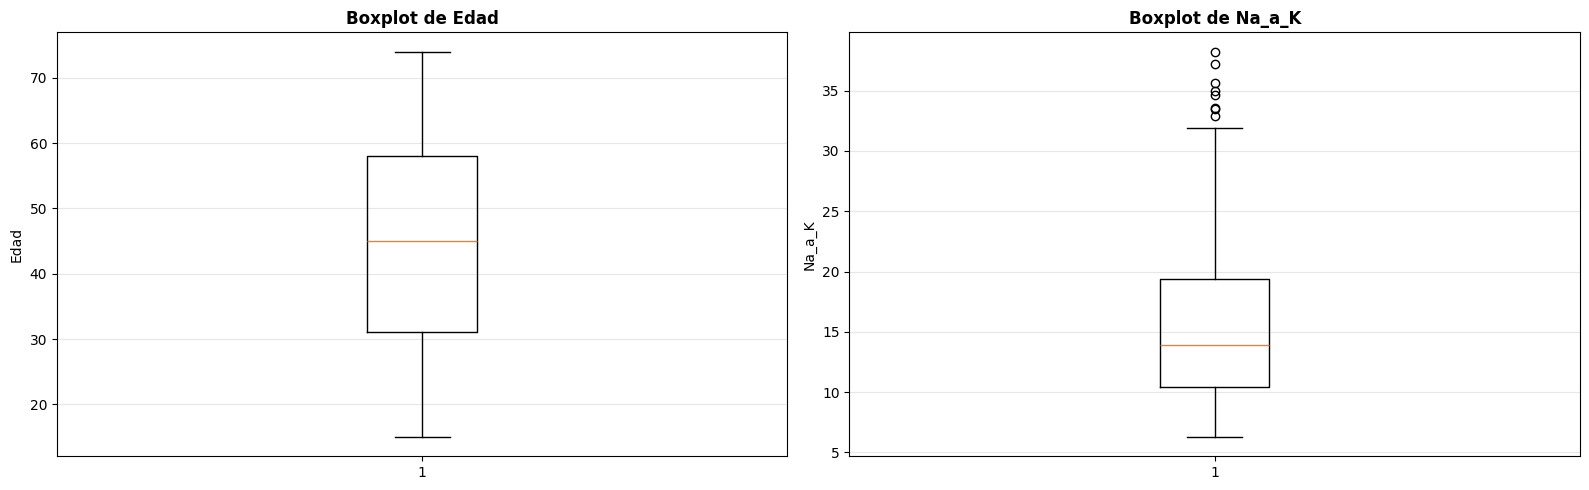

In [268]:
# Boxplots de las 2 variables predictoras numéricas

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for i, col in enumerate(numericas_drogas):
    axes[i].boxplot(datos_drogas[col], vert=True)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Boxplot de {col}', fontweight='bold')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

A partir de los boxplots de las variables numéricas no se observan outliers extremos que comprometan el ajuste, y dado el tamaño reducido del dataset (n=200), eliminar observaciones podría degradar el desempeño por pérdida de información. Por estos motivos se decide no remover outliers en esta etapa.

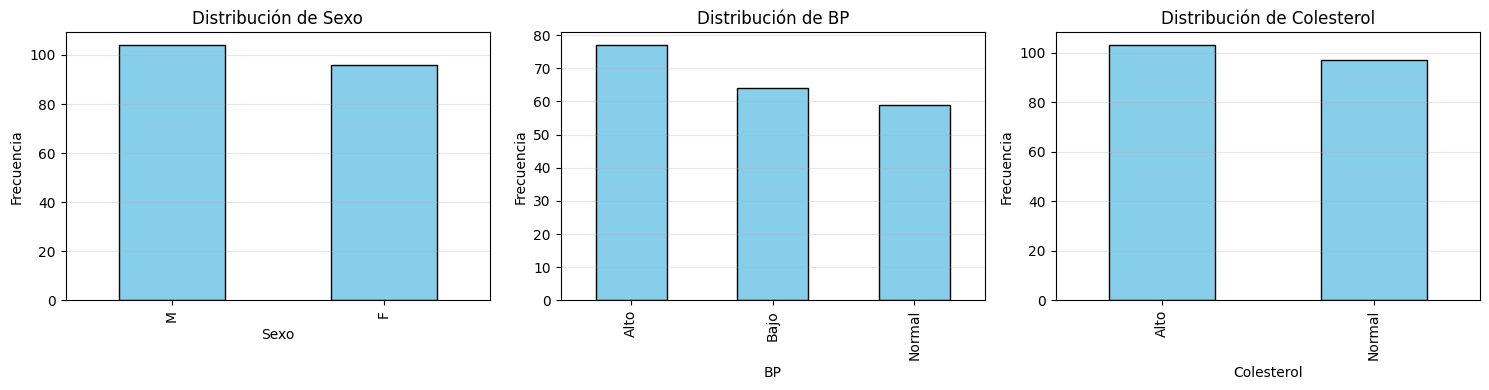

In [269]:
# Distribución de variables categóricas

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, ['Sexo','BP','Colesterol']):
    datos_drogas[col].value_counts().plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col); ax.set_ylabel('Frecuencia'); ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

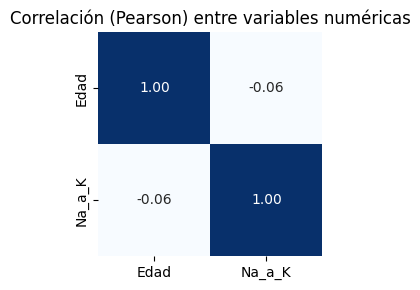

In [270]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr_num = datos_drogas[['Edad','Na_a_K']].corr(method='pearson')
plt.figure(figsize=(3,3))
sns.heatmap(corr_num, annot=True, fmt='.2f', cmap='Blues', square=True, cbar=False)
plt.title('Correlación (Pearson) entre variables numéricas')
plt.tight_layout(); plt.show()

Usamos Pearson porque mide la correlación lineal entre variables numéricas continuas. Se observa una correlación prácticamente nula entre Edad y Na_a_K (r ≈ −0.06), por lo que no existe relación lineal fuerte entre ellas. Esto sugiere que las dos variables aportan información distinta y que no hay riesgo de multicolinealidad entre las numéricas. 

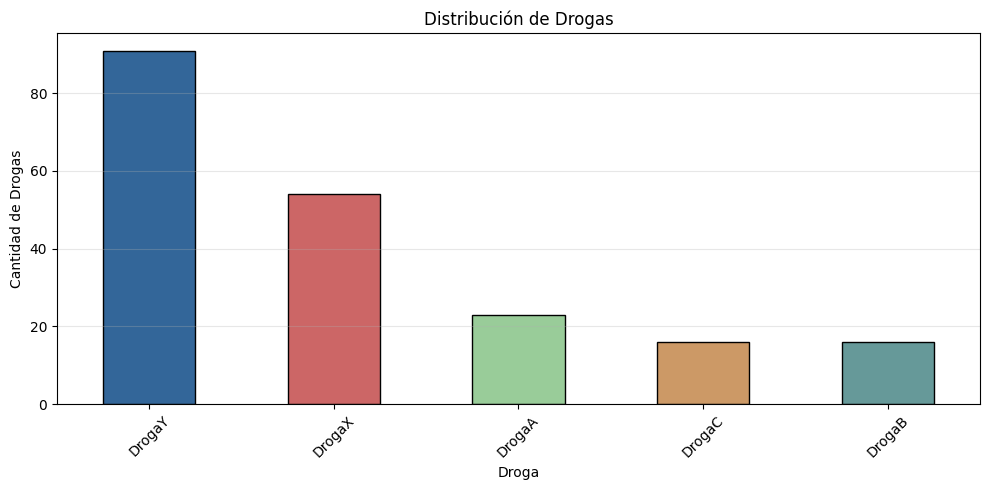

CONTEO DE DROGAS:
Droga
DrogaY    91
DrogaX    54
DrogaA    23
DrogaC    16
DrogaB    16
Name: count, dtype: int64
PORCENTAJE:
Droga
DrogaY    45.5
DrogaX    27.0
DrogaA    11.5
DrogaC     8.0
DrogaB     8.0
Name: count, dtype: float64


In [271]:
# Distribución de la variable objetivo
conteo_drogas = datos_drogas['Droga'].value_counts()

paleta = ['#336699', '#CC6666', '#99CC99', '#CC9966', '#669999']

plt.figure(figsize=(10, 5))
conteo_drogas.plot(kind='bar', color=paleta, edgecolor='black')
plt.xlabel('Droga')
plt.ylabel('Cantidad de Drogas')
plt.title('Distribución de Drogas')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


# Conteo de drogas + porcentaje
conteo_drogas = datos_drogas['Droga'].value_counts()
pct_drogas = conteo_drogas / conteo_drogas.sum() * 100
print(f"CONTEO DE DROGAS:\n{conteo_drogas}")
print("=" * 50)
print(f"PORCENTAJE:\n{pct_drogas}")

### podriamos agregar barras para Sexo, BP, Colesterol.. y faltan correlaciones 

## Preprocesamiento 

In [272]:
# 1.1 Columnas y X/y
cat_cols = ['Sexo', 'BP', 'Colesterol']
num_cols = ['Edad', 'Na_a_K']

X = datos_drogas.drop(columns='Droga')
y = datos_drogas['Droga']

# 1.2 Dos splits estratificados
X_tr80, X_te80, y_tr80, y_te80 = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_tr70, X_te70, y_tr70, y_te70 = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print('80/20 ->', X_tr80.shape, X_te80.shape)
print('70/30 ->', X_tr70.shape, X_te70.shape)
print('Distribución 80/20 train (%):\n', (y_tr80.value_counts(normalize=True)*100).round(1))
print('Distribución 70/30 train (%):\n', (y_tr70.value_counts(normalize=True)*100).round(1))



80/20 -> (160, 5) (40, 5)
70/30 -> (140, 5) (60, 5)
Distribución 80/20 train (%):
 Droga
DrogaY    45.6
DrogaX    26.9
DrogaA    11.2
DrogaC     8.1
DrogaB     8.1
Name: proportion, dtype: float64
Distribución 70/30 train (%):
 Droga
DrogaY    45.7
DrogaX    27.1
DrogaA    11.4
DrogaC     7.9
DrogaB     7.9
Name: proportion, dtype: float64


In [273]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop' # Elimina columnas no usadas
)

def baseline_scores(y_train, y_test):
    majority = y_train.value_counts().idxmax()
    y_pred = np.full(shape=len(y_test), fill_value=majority, dtype=object)
    return {
        'majority': majority,
        'acc': round(accuracy_score(y_test, y_pred), 3),
        'prec_macro': round(precision_score(y_test, y_pred, average='macro', zero_division=0), 3),
        'rec_macro': round(recall_score(y_test, y_pred, average='macro', zero_division=0), 3),
        'f1_macro': round(f1_score(y_test, y_pred, average='macro', zero_division=0), 3),
    }

bl_80 = baseline_scores(y_tr80, y_te80)
bl_70 = baseline_scores(y_tr70, y_te70)
print('Baseline 80/20:', bl_80)
print('Baseline 70/30:', bl_70)


Baseline 80/20: {'majority': 'DrogaY', 'acc': 0.45, 'prec_macro': 0.09, 'rec_macro': 0.2, 'f1_macro': 0.124}
Baseline 70/30: {'majority': 'DrogaY', 'acc': 0.45, 'prec_macro': 0.09, 'rec_macro': 0.2, 'f1_macro': 0.124}


Este baseline nos sirve para dimensionar el desbalance del conjunto: si siempre predecimos la clase mayoritaria (DrogaY), obtengo 45% de accuracy pero métricas macro muy bajas, lo que indica que casi no reconocemos las clases minoritarias. A partir de ahora, cualquier modelo razonable debe superar ese 45% y sobre todo, mejorar las métricas macro y la matriz de confusión en las clases menos frecuentes. 

Usamos como referencia sklearn.dummy.DummyClassifier para crear el baseline: 

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

## Entrenamientos

In [274]:
tree_pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(random_state=42))  # Entrenamos primero sin class_weight
])

# Parametros para GridSearchCV
param_grid = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [None, 3, 5, 7, 9],
    'model__min_samples_leaf': [1, 2, 3, 5],
    'model__min_samples_split': [2, 5, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid80 = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)
grid70 = GridSearchCV(
    estimator=tree_pipe,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

grid80.fit(X_tr80, y_tr80)
best80 = grid80.best_estimator_
print('Mejores parametros 80/20:', grid80.best_params_)

grid70.fit(X_tr70, y_tr70)
best70 = grid70.best_estimator_
print('Mejores parametros 70/30:', grid70.best_params_)

Mejores parametros 80/20: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Mejores parametros 70/30: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


In [275]:
# =============================================================================
# CELDA: Funciones auxiliares para clasificación
# =============================================================================

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_mat(y_true, y_pred, title='Matriz de Confusión'):
    """Dibuja una matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y_true.unique()),
                yticklabels=sorted(y_true.unique()),
                cbar=True)
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=13)
    plt.tight_layout()
    plt.show()

print("✓ Función plot_conf_mat definida")

✓ Función plot_conf_mat definida



=== Árbol (sin poda) - Test 80/20 ===
Accuracy: 0.975
Precision (macro): 0.9666666666666668
Recall (macro): 0.9333333333333332


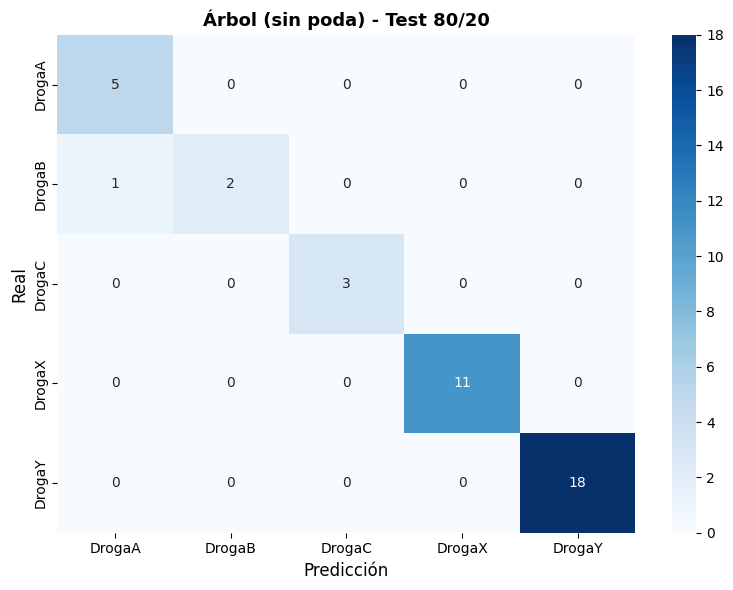


=== Árbol (sin poda) - Test 70/30 ===
Accuracy: 0.9833333333333333
Precision (macro): 0.975
Recall (macro): 0.96


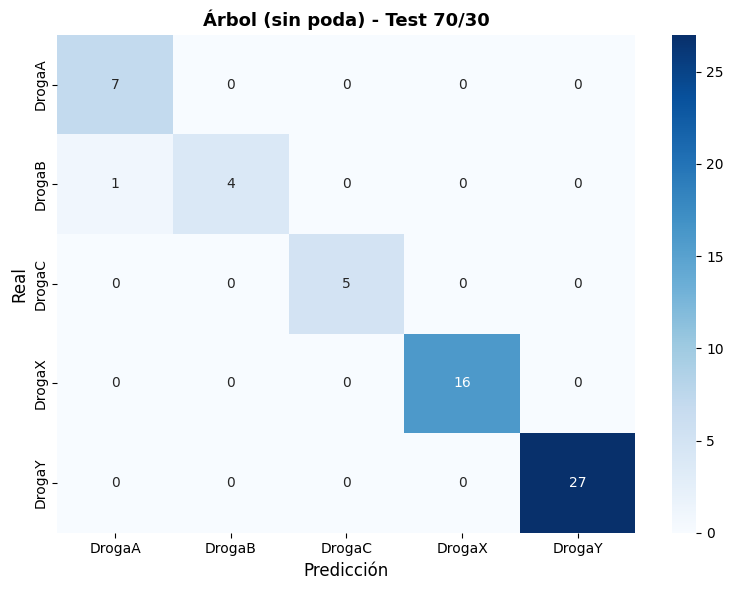

In [276]:
# 80/20
y_pred80 = best80.predict(X_te80)
print('\n=== Árbol (sin poda) - Test 80/20 ===')
print('Accuracy:', accuracy_score(y_te80, y_pred80))
print('Precision (macro):', precision_score(y_te80, y_pred80, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te80, y_pred80, average='macro', zero_division=0))
plot_conf_mat(y_te80, y_pred80, 'Árbol (sin poda) - Test 80/20')

# 70/30
y_pred70 = best70.predict(X_te70)
print('\n=== Árbol (sin poda) - Test 70/30 ===')
print('Accuracy:', accuracy_score(y_te70, y_pred70))
print('Precision (macro):', precision_score(y_te70, y_pred70, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te70, y_pred70, average='macro', zero_division=0))
plot_conf_mat(y_te70, y_pred70, 'Árbol (sin poda) - Test 70/30')

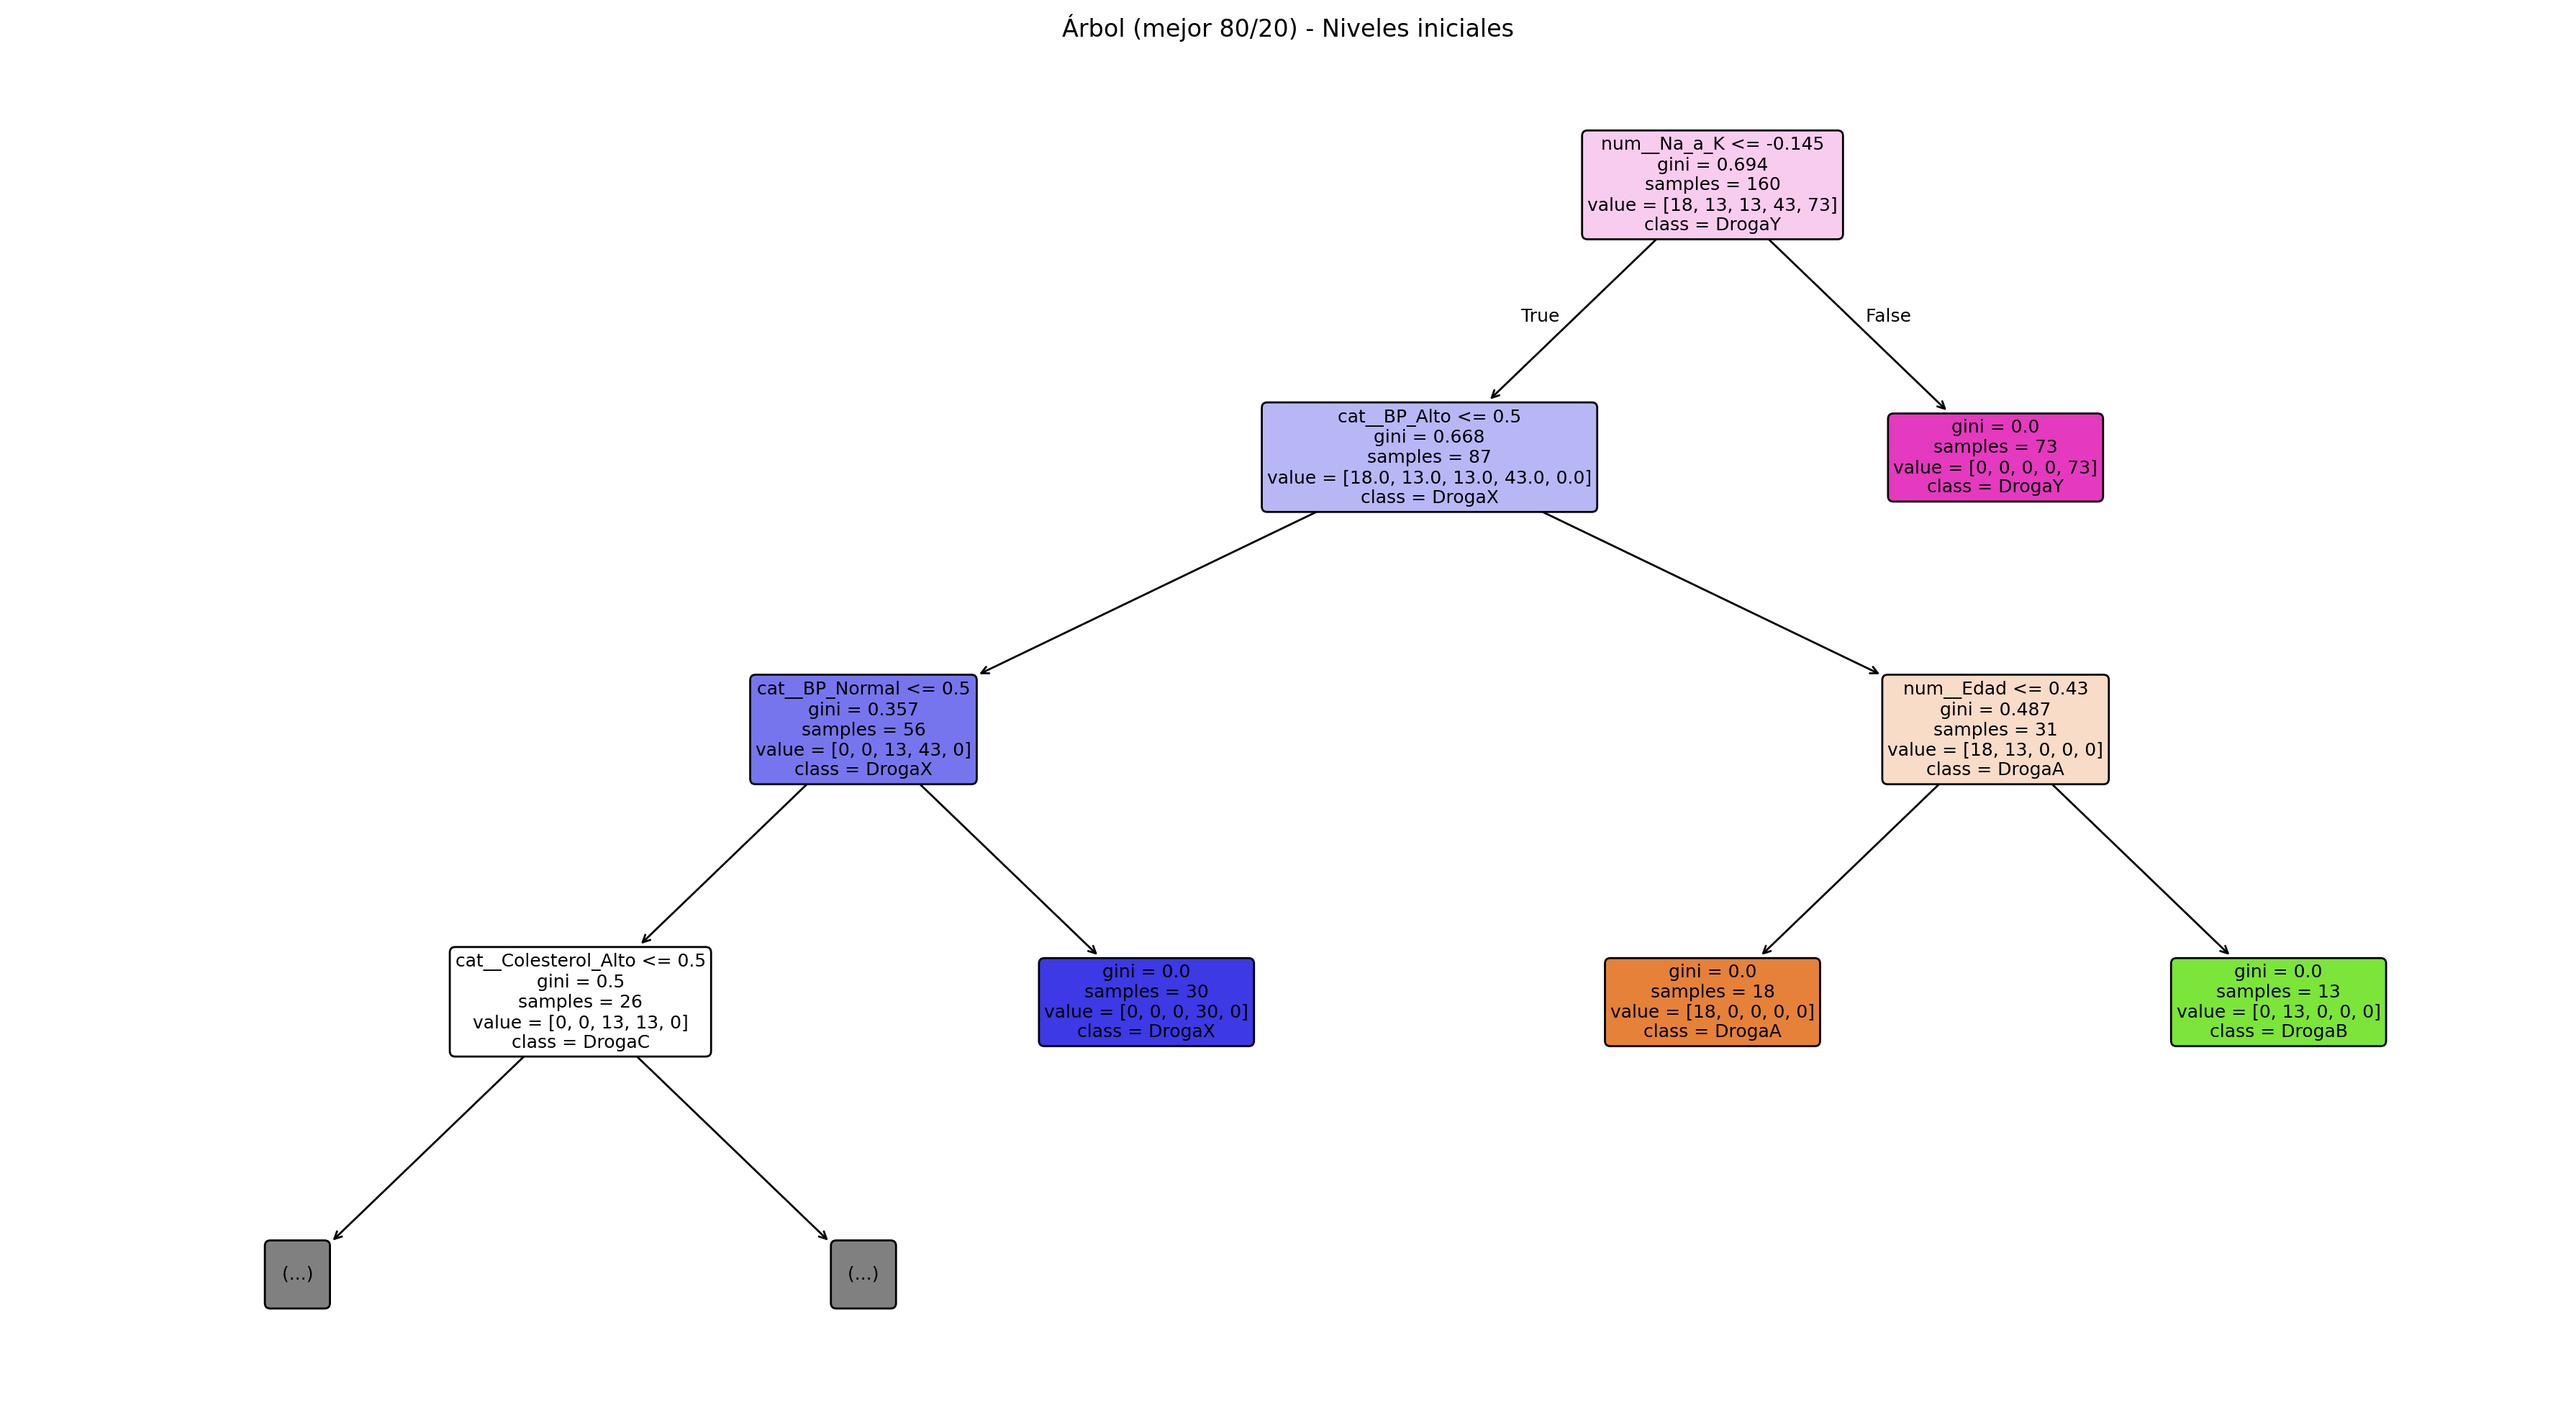

In [277]:
feat_names_80 = best80.named_steps['prep'].get_feature_names_out()
clf80 = best80.named_steps['model']

plt.figure(figsize=(18, 10), dpi=200)
plot_tree(
    clf80,
    feature_names=feat_names_80,
    class_names=sorted(y_tr80.unique()),
    filled=True, rounded=True,
    max_depth=3,          # limitamos para legibilidad del gráfico
    fontsize=9
)
plt.title('Árbol (mejor 80/20) - Niveles iniciales')
plt.tight_layout()
plt.show()

Alpha seleccionado (80/20): 0.0

 Árbol PODADO - Test 80/20
Accuracy: 0.975
Precision (macro): 0.9666666666666668
Recall (macro): 0.9333333333333332


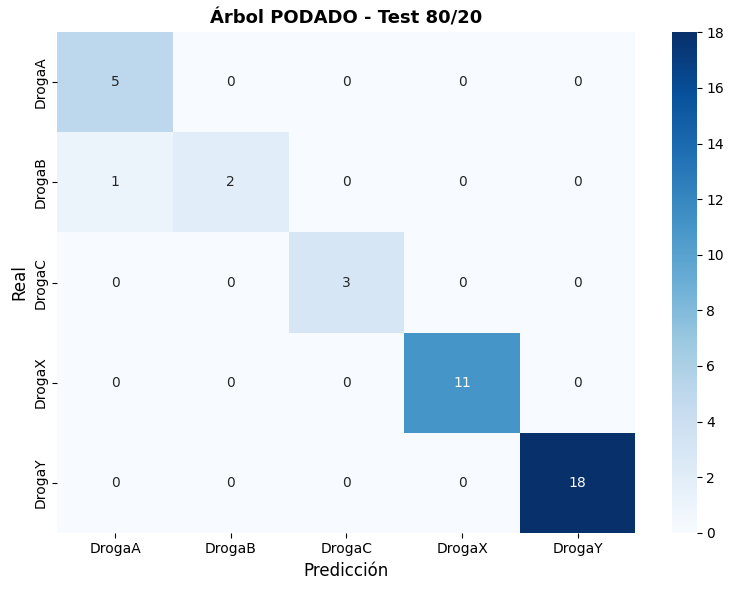

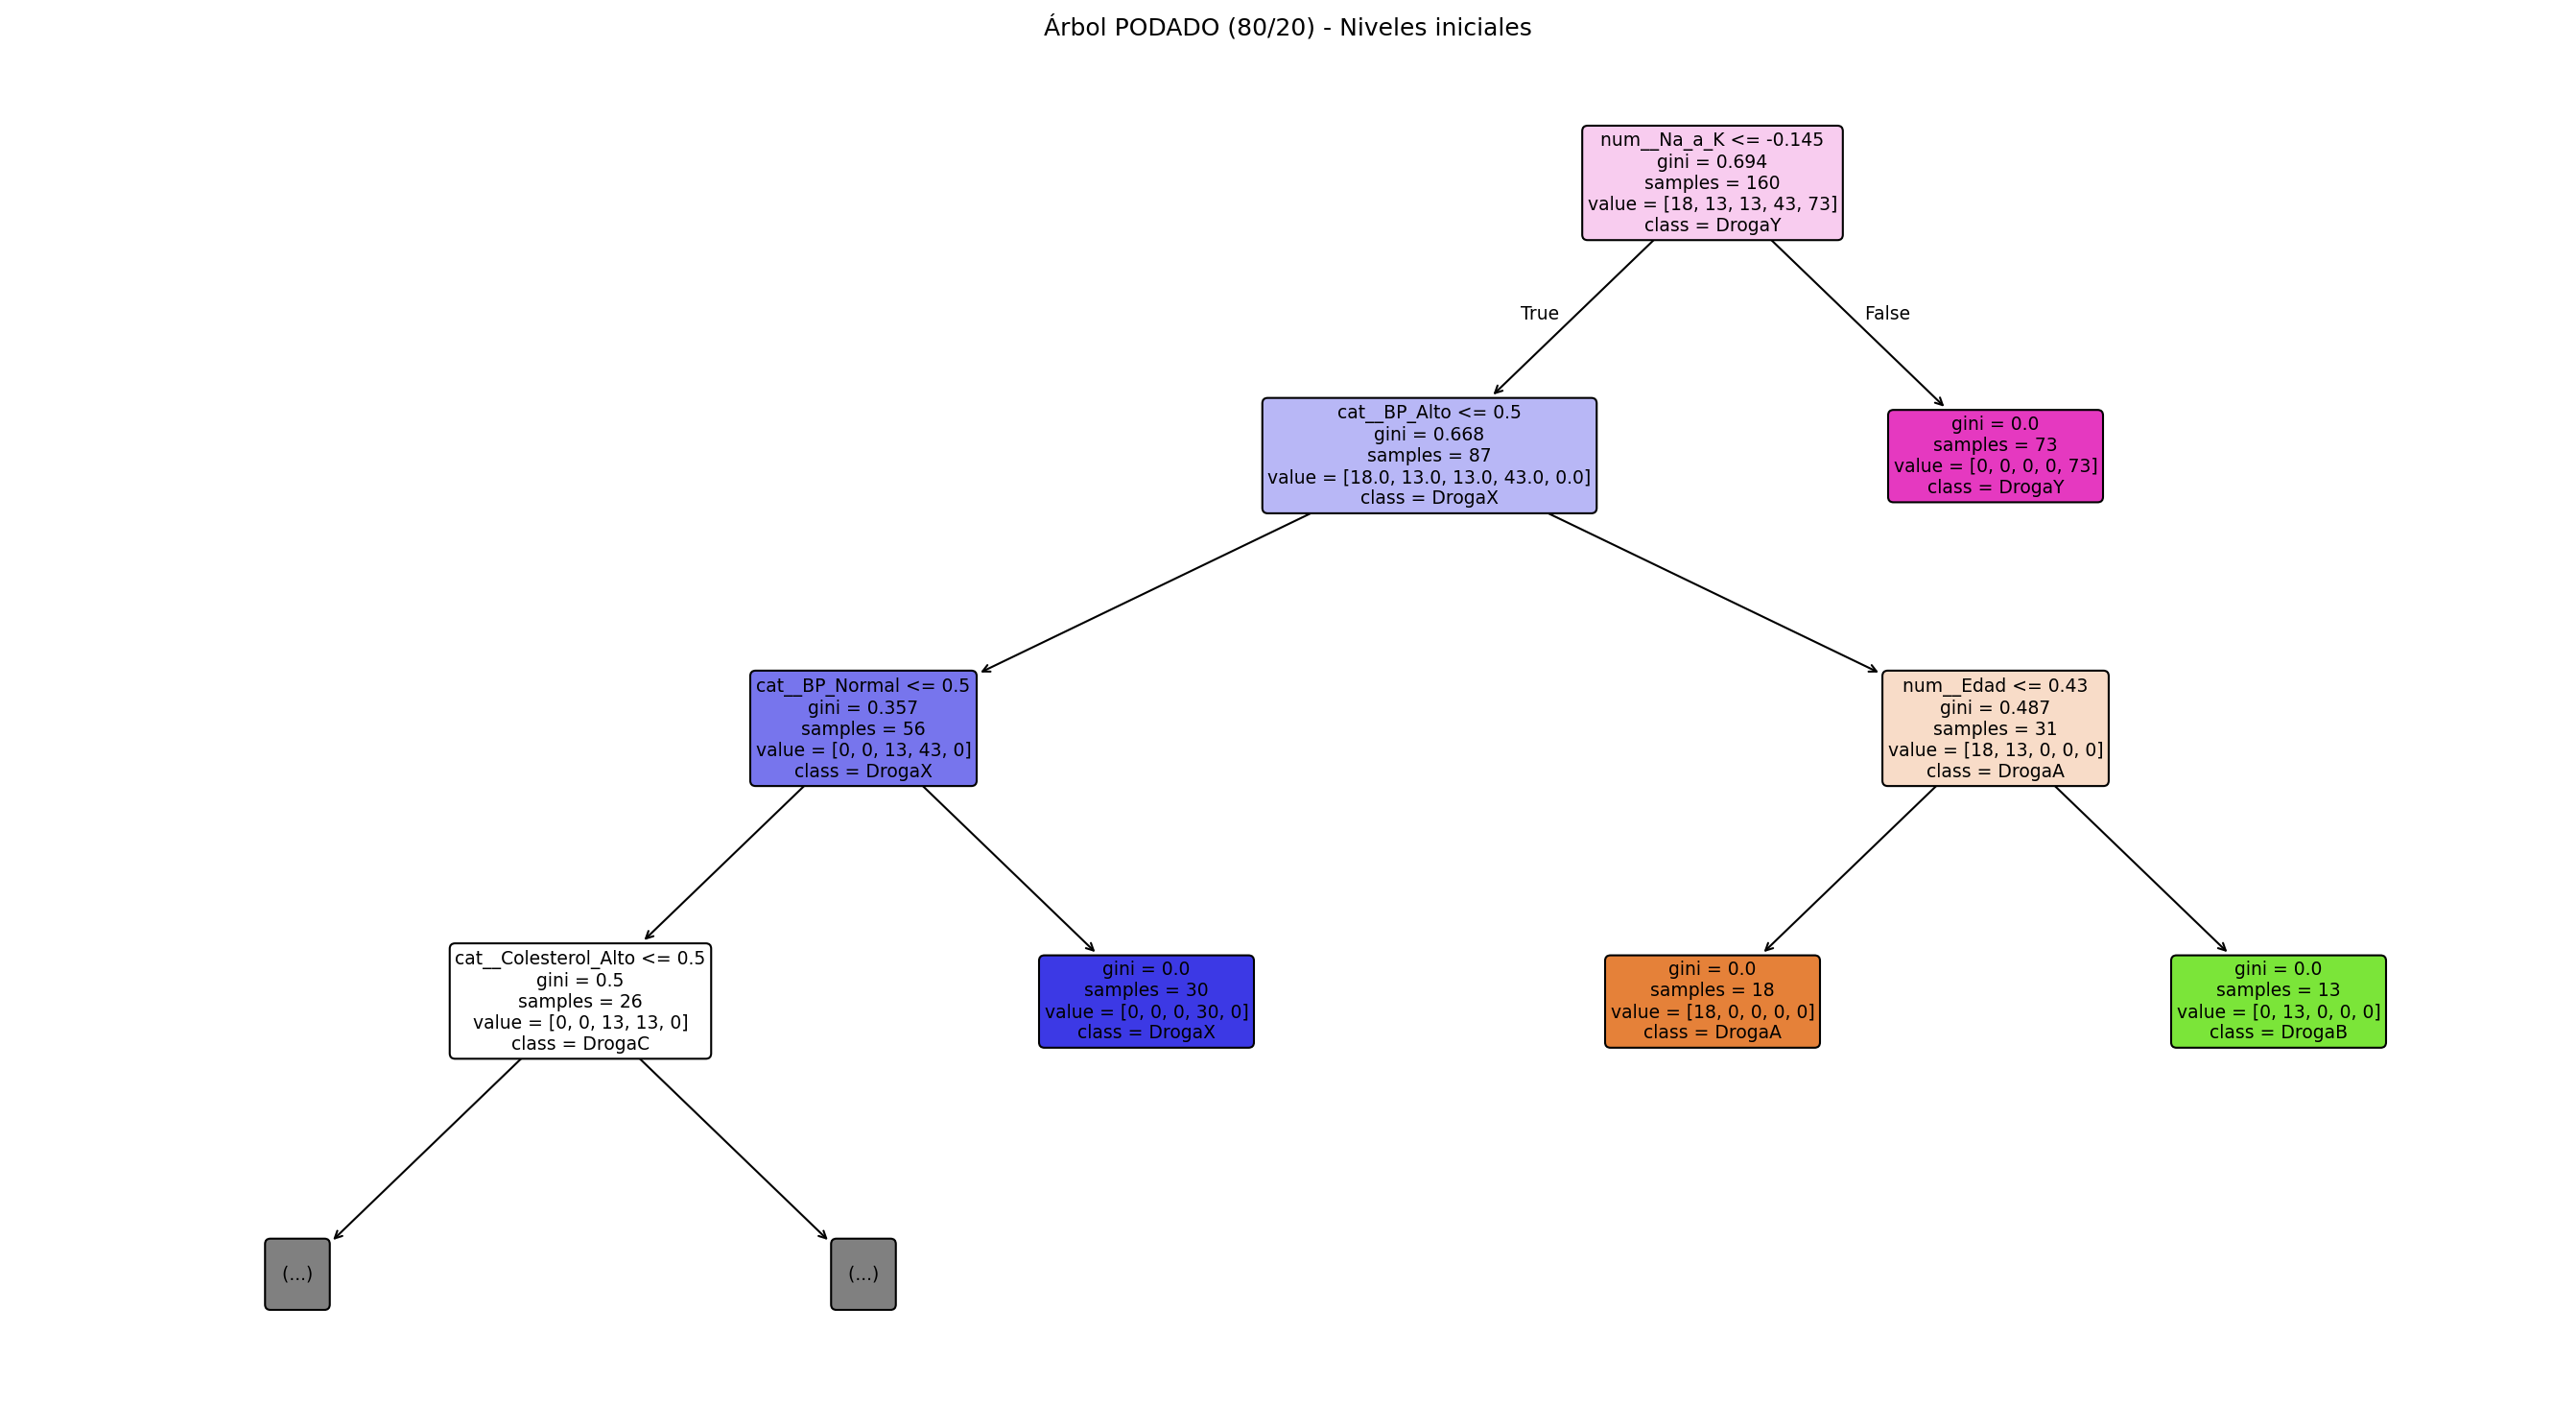

In [278]:
import numpy as np
from sklearn.model_selection import cross_val_score

# Transformo el train (80/20) una sola vez para evaluar poda sin rehacer preprocesamiento
Xt_tr80 = best80.named_steps['prep'].transform(X_tr80)
y_tr80_arr = np.asarray(y_tr80)

# Camino de complejidad (alpha candidates)
tmp_tree = DecisionTreeClassifier(
    criterion=best80.named_steps['model'].criterion,
    max_depth=best80.named_steps['model'].max_depth,
    min_samples_leaf=best80.named_steps['model'].min_samples_leaf,
    min_samples_split=best80.named_steps['model'].min_samples_split,
    random_state=42
)
path = tmp_tree.cost_complexity_pruning_path(Xt_tr80, y_tr80_arr)
ccp_alphas = np.unique(np.round(path.ccp_alphas, 6))

# Selección de alpha por CV (f1_macro)
scores = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        criterion=tmp_tree.criterion,
        max_depth=tmp_tree.max_depth,
        min_samples_leaf=tmp_tree.min_samples_leaf,
        min_samples_split=tmp_tree.min_samples_split,
        ccp_alpha=alpha,
        random_state=42
    )
    cv_score = cross_val_score(clf, Xt_tr80, y_tr80_arr, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    scores.append(cv_score)

best_alpha = float(ccp_alphas[int(np.argmax(scores))])
print('Alpha seleccionado (80/20):', best_alpha)

# Entreno pipeline "podado": mismo preprocesamiento + ccp_alpha óptimo
pruned80 = Pipeline(steps=[
    ('prep', best80.named_steps['prep']),
    ('model', DecisionTreeClassifier(
        criterion=tmp_tree.criterion,
        max_depth=tmp_tree.max_depth,
        min_samples_leaf=tmp_tree.min_samples_leaf,
        min_samples_split=tmp_tree.min_samples_split,
        ccp_alpha=best_alpha,
        random_state=42
    ))
])
pruned80.fit(X_tr80, y_tr80)

# Evaluación podado 80/20
y_pred80_pruned = pruned80.predict(X_te80)
print('\n Árbol PODADO - Test 80/20')
print('Accuracy:', accuracy_score(y_te80, y_pred80_pruned))
print('Precision (macro):', precision_score(y_te80, y_pred80_pruned, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te80, y_pred80_pruned, average='macro', zero_division=0))
plot_conf_mat(y_te80, y_pred80_pruned, 'Árbol PODADO - Test 80/20')

# Graficar árbol podado (80/20)
feat_names_80 = pruned80.named_steps['prep'].get_feature_names_out()
plt.figure(figsize=(18, 10), dpi=150)
plot_tree(
    pruned80.named_steps['model'],
    feature_names=feat_names_80,
    class_names=sorted(y_tr80.unique()),
    filled=True, rounded=True,
    max_depth=3,
    fontsize=9
)
plt.title('Árbol PODADO (80/20) - Niveles iniciales')
plt.tight_layout()
plt.show()

Alpha seleccionado (70/30): 0.0

 Árbol PODADO - Test 70/30
Accuracy: 0.9833333333333333
Precision (macro): 0.975
Recall (macro): 0.96


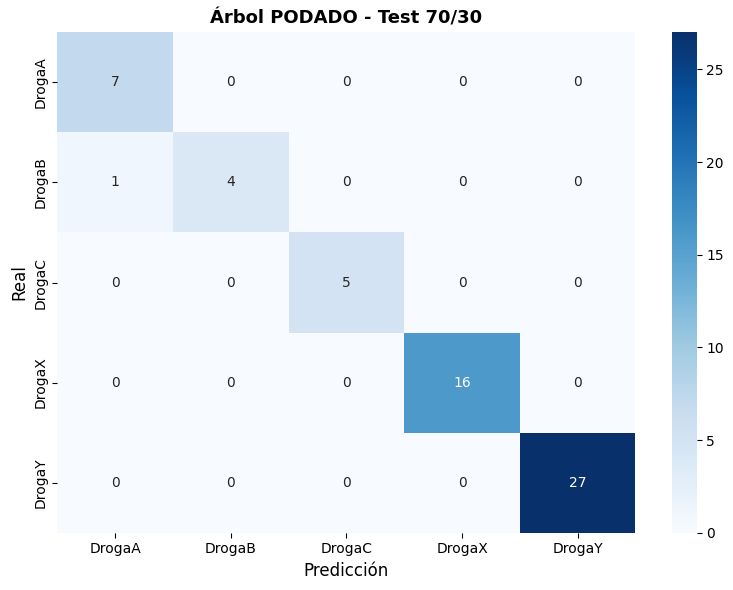

In [ ]:
# Transformamos el train (70/30)
Xt_tr70 = best70.named_steps['prep'].transform(X_tr70)
y_tr70_arr = np.asarray(y_tr70)

tmp_tree70 = DecisionTreeClassifier(
    criterion=best70.named_steps['model'].criterion,
    max_depth=best70.named_steps['model'].max_depth,
    min_samples_leaf=best70.named_steps['model'].min_samples_leaf,
    min_samples_split=best70.named_steps['model'].min_samples_split,
    random_state=42
)
path70 = tmp_tree70.cost_complexity_pruning_path(Xt_tr70, y_tr70_arr)
ccp_alphas70 = np.unique(np.round(path70.ccp_alphas, 6))

scores70 = []
for alpha in ccp_alphas70:
    clf = DecisionTreeClassifier(
        criterion=tmp_tree70.criterion,
        max_depth=tmp_tree70.max_depth,
        min_samples_leaf=tmp_tree70.min_samples_leaf,
        min_samples_split=tmp_tree70.min_samples_split,
        ccp_alpha=alpha,
        random_state=42
    )
    cv_score = cross_val_score(clf, Xt_tr70, y_tr70_arr, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    scores70.append(cv_score)

best_alpha70 = float(ccp_alphas70[int(np.argmax(scores70))])
print('Alpha seleccionado (70/30):', best_alpha70)

pruned70 = Pipeline(steps=[
    ('prep', best70.named_steps['prep']),
    ('model', DecisionTreeClassifier(
        criterion=tmp_tree70.criterion,
        max_depth=tmp_tree70.max_depth,
        min_samples_leaf=tmp_tree70.min_samples_leaf,
        min_samples_split=tmp_tree70.min_samples_split,
        ccp_alpha=best_alpha70,
        random_state=42
    ))
])
pruned70.fit(X_tr70, y_tr70)

y_pred70_pruned = pruned70.predict(X_te70)
print('\n Árbol PODADO - Test 70/30')
print('Accuracy:', accuracy_score(y_te70, y_pred70_pruned))
print('Precision (macro):', precision_score(y_te70, y_pred70_pruned, average='macro', zero_division=0))
print('Recall (macro):', recall_score(y_te70, y_pred70_pruned, average='macro', zero_division=0))
plot_conf_mat(y_te70, y_pred70_pruned, 'Árbol PODADO - Test 70/30')

El árbol de clasificación muestra un desempeño muy alto y consistente en ambos splits (80/20 y 70/30), con accuracy entre 0.97 y 0.98 y métricas macro (precisión y exhaustividad) también elevadas, superando ampliamente la línea de base. La búsqueda de hiperparámetros indicó criterion='gini', max_depth=None, min_samples_leaf=1 y min_samples_split=2. El análisis de poda mediante el camino de complejidad seleccionó ccp_alpha = 0.0, por lo que no se observó mejora al podar: el modelo sin poda ya optimiza el rendimiento según validación cruzada. Las matrices de confusión confirman que el clasificador identifica correctamente tanto la clase mayoritaria como las minoritarias.

## 5: Naive Bayes


In [280]:
warnings.filterwarnings('ignore')

### Dataset 1 - División 80/20

In [299]:
#Creamos Dummies para una mayor precición en el modelo
X_tr80_prep = pd.get_dummies(X_tr80, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)
X_te80_prep = pd.get_dummies(X_te80, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)
X_tr70_prep = pd.get_dummies(X_tr70, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)
X_te70_prep = pd.get_dummies(X_te70, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)


In [300]:
X_te80_prep = X_te80_prep.reindex(columns=X_tr80_prep.columns, fill_value=0)
X_te70_prep = X_te70_prep.reindex(columns=X_tr70_prep.columns, fill_value=0)

Exactitud:  0.8000
Precision: 0.7533
Exhaustividad: 0.8556


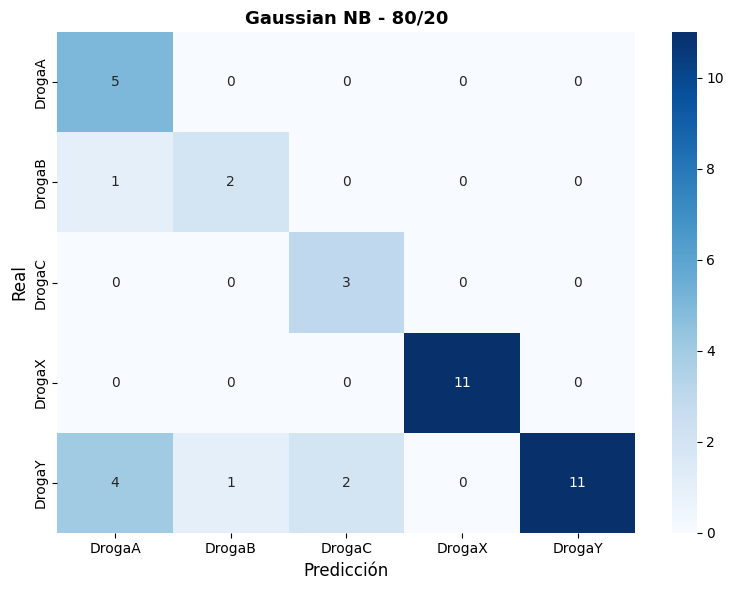

In [301]:
gnb_80 = GaussianNB()
gnb_80.fit(X_tr80_prep, y_tr80)
pred_gnb_80 = gnb_80.predict(X_te80_prep)

acc_gnb_80 = accuracy_score(y_te80, pred_gnb_80)
prec_gnb_80 = precision_score(y_te80, pred_gnb_80, average='macro')
rec_gnb_80 = recall_score(y_te80, pred_gnb_80, average='macro')

print(f'Exactitud:  {acc_gnb_80:.4f}')
print(f'Precision: {prec_gnb_80:.4f}')
print(f'Exhaustividad: {rec_gnb_80:.4f}')

plot_conf_mat(y_te80, pred_gnb_80, 'Gaussian NB - 80/20')

### Dataset 2 - División 70/30

In [284]:
X_tr80_prep = pd.get_dummies(X_tr80, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)
X_te80_prep = pd.get_dummies(X_te80, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)
X_tr70_prep = pd.get_dummies(X_tr70, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)
X_te70_prep = pd.get_dummies(X_te70, columns=['Sexo', 'BP', 'Colesterol'], drop_first=False)

In [285]:
X_te80_prep = X_te80_prep.reindex(columns=X_tr80_prep.columns, fill_value=0)
X_te70_prep = X_te70_prep.reindex(columns=X_tr70_prep.columns, fill_value=0)

Exactitud:  0.7500
Precision: 0.7422
Exhaustividad: 0.8563


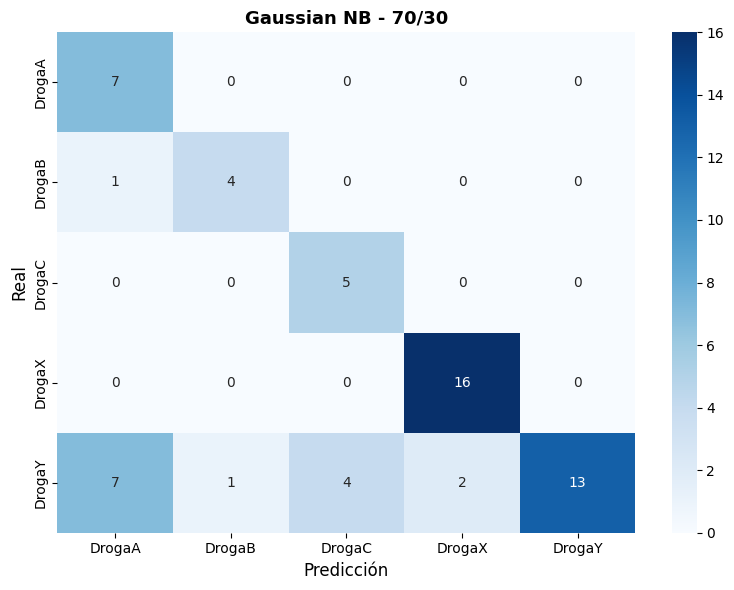

In [292]:
gnb_70 = GaussianNB()
gnb_70.fit(X_tr70_prep, y_tr70)
pred_gnb_70 = gnb_70.predict(X_te70_prep)

acc_gnb_70 = accuracy_score(y_te70, pred_gnb_70)
prec_gnb_70 = precision_score(y_te70, pred_gnb_70, average='macro')
rec_gnb_70 = recall_score(y_te70, pred_gnb_70, average='macro')

print(f'Exactitud:  {acc_gnb_70:.4f}')
print(f'Precision: {prec_gnb_70:.4f}')
print(f'Exhaustividad: {rec_gnb_70:.4f}')

plot_conf_mat(y_te70, pred_gnb_70, 'Gaussian NB - 70/30')


### Categorical Naive Bayes con discretización

In [306]:
estrategias = ['uniform', 'quantile', 'kmeans']
bins_opciones = [3, 5, 7, 10]

resultados = []

for strategy in estrategias:
    for n_bins in bins_opciones:
        #Discretizamos las variables continuas
        disc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        
        X_tr_disc = X_tr80_prep.copy()
        X_te_disc = X_te80_prep.copy()
        
        X_tr_disc[['Edad', 'Na_a_K']] = disc.fit_transform(X_tr80_prep[['Edad', 'Na_a_K']])
        X_te_disc[['Edad', 'Na_a_K']] = disc.transform(X_te80_prep[['Edad', 'Na_a_K']])
        
        #Modelo
        cnb = CategoricalNB()
        cnb.fit(X_tr_disc, y_tr80)
        pred = cnb.predict(X_te_disc)
        
        #Métricas
        acc = accuracy_score(y_te80, pred)
        prec = precision_score(y_te80, pred, average='macro')
        rec = recall_score(y_te80, pred, average='macro')
        
        resultados.append({
            'Strategy': strategy,
            'n_bins': n_bins,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec
        })

#Tabla de resultados
df_resultados = pd.DataFrame(resultados)
print("\nResultados exploración (80/20):")
print(df_resultados.to_string(index=False))

#Mejor configuración
mejor = df_resultados.loc[df_resultados['Accuracy'].idxmax()]
print(f"\nMejor configuración:")
print(f"  Estrategia: {mejor['Strategy']}")
print(f"  N bins:     {int(mejor['n_bins'])}")
print(f"  Exactitud:   {mejor['Accuracy']:.4f}")


Resultados exploración (80/20):
Strategy  n_bins  Accuracy  Precision   Recall
 uniform       3     0.850   0.745000 0.822222
 uniform       5     0.725   0.703509 0.716566
 uniform       7     0.900   0.862857 0.844444
 uniform      10     0.900   0.874167 0.948485
quantile       3     0.750   0.693611 0.756566
quantile       5     0.850   0.806471 0.890303
quantile       7     0.875   0.845000 0.833333
quantile      10     0.850   0.820635 0.759596
  kmeans       3     0.950   0.942857 0.866667
  kmeans       5     0.675   0.627619 0.638788
  kmeans       7     0.925   0.892857 0.855556
  kmeans      10     0.975   0.950000 0.988889

Mejor configuración:
  Estrategia: kmeans
  N bins:     10
  Exactitud:   0.9750


### Entrenamos con mejor configuración en 70/30

Exactitud:  0.9000
Precision: 0.8750
Exhaustividad: 0.9556


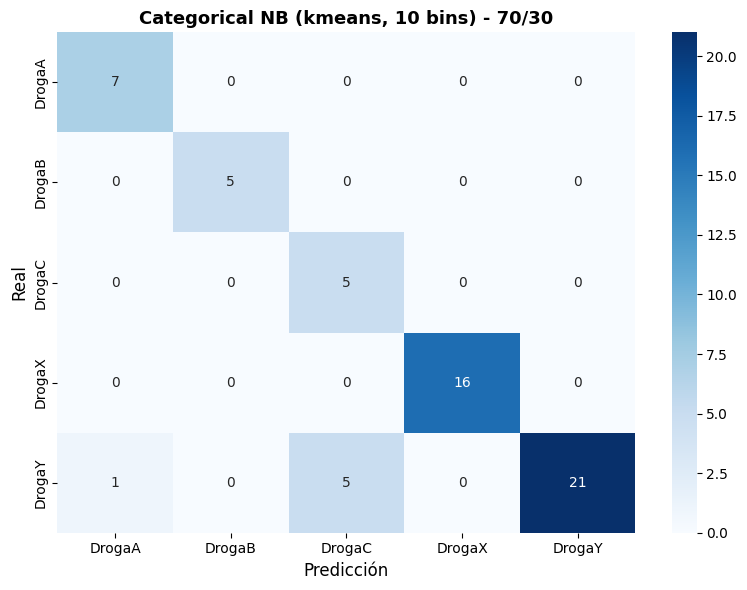

In [304]:
mejor_disc = KBinsDiscretizer(n_bins=int(mejor['n_bins']), encode='ordinal', 
                              strategy=mejor['Strategy'])

X_tr70_disc = X_tr70_prep.copy()
X_te70_disc = X_te70_prep.copy()

X_tr70_disc[['Edad', 'Na_a_K']] = mejor_disc.fit_transform(X_tr70_prep[['Edad', 'Na_a_K']])
X_te70_disc[['Edad', 'Na_a_K']] = mejor_disc.transform(X_te70_prep[['Edad', 'Na_a_K']])

cnb_70 = CategoricalNB()
cnb_70.fit(X_tr70_disc, y_tr70)
pred_cnb_70 = cnb_70.predict(X_te70_disc)

acc_cnb_70 = accuracy_score(y_te70, pred_cnb_70)
prec_cnb_70 = precision_score(y_te70, pred_cnb_70, average='macro')
rec_cnb_70 = recall_score(y_te70, pred_cnb_70, average='macro')

print(f'Exactitud:  {acc_cnb_70:.4f}')
print(f'Precision: {prec_cnb_70:.4f}')
print(f'Exhaustividad: {rec_cnb_70:.4f}')

plot_conf_mat(y_te70, pred_cnb_70, 
              f'Categorical NB ({mejor["Strategy"]}, {int(mejor["n_bins"])} bins) - 70/30')

### Resumen comparativo


In [305]:
resultados_nb = pd.DataFrame({
    'Modelo': [
        'Gaussian NB',
        'Gaussian NB',
        f'Categorical NB ({mejor["Strategy"]}, {int(mejor["n_bins"])} bins)',
        f'Categorical NB ({mejor["Strategy"]}, {int(mejor["n_bins"])} bins)'
    ],
    'Split': ['80/20', '70/30', '80/20', '70/30'],
    'Accuracy': [acc_gnb_80, acc_gnb_70, mejor['Accuracy'], acc_cnb_70],
    'Precision': [prec_gnb_80, prec_gnb_70, mejor['Precision'], prec_cnb_70],
    'Recall': [rec_gnb_80, rec_gnb_70, mejor['Recall'], rec_cnb_70]
})


print(resultados_nb.to_string(index=False))

                          Modelo Split  Accuracy  Precision   Recall
                     Gaussian NB 80/20     0.800   0.753333 0.855556
                     Gaussian NB 70/30     0.750   0.742222 0.856296
Categorical NB (kmeans, 10 bins) 80/20     0.975   0.950000 0.988889
Categorical NB (kmeans, 10 bins) 70/30     0.900   0.875000 0.955556
